In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 245)
(2, 245)


[I 2025-06-06 23:10:46,428] A new study created in memory with name: no-name-bbddef16-a676-4202-86f0-306d7a99baca
[I 2025-06-06 23:13:55,224] Trial 0 finished with value: 0.08167693093419075 and parameters: {'lr': 0.0018956186440534809, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3565251584532939}. Best is trial 0 with value: 0.08167693093419075.


Cross Validation Accuracies:
[0.05883898213505745, 0.0940154418349266, 0.0795196071267128, 0.10997596383094788, 0.06603465974330902]
Mean Cross Validation Accuracy:
0.08167693093419075
Standard Deviation of Cross Validation Accuracy:
0.018568687156126862


[I 2025-06-06 23:17:31,111] Trial 1 finished with value: 0.21766447722911836 and parameters: {'lr': 0.05901492662368661, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.21635547388216417}. Best is trial 0 with value: 0.08167693093419075.


Cross Validation Accuracies:
[0.20154514908790588, 0.21641361713409424, 0.23819831013679504, 0.2386460155248642, 0.19351929426193237]
Mean Cross Validation Accuracy:
0.21766447722911836
Standard Deviation of Cross Validation Accuracy:
0.018472955878020884


[I 2025-06-06 23:20:38,742] Trial 2 finished with value: 0.15277014076709747 and parameters: {'lr': 0.0012580773750323732, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.20310152492732045}. Best is trial 0 with value: 0.08167693093419075.


Cross Validation Accuracies:
[0.15142743289470673, 0.12332135438919067, 0.13273601233959198, 0.16347187757492065, 0.19289402663707733]
Mean Cross Validation Accuracy:
0.15277014076709747
Standard Deviation of Cross Validation Accuracy:
0.024473878210953978


[I 2025-06-06 23:23:42,247] Trial 3 finished with value: 0.4050934374332428 and parameters: {'lr': 0.11582519228551988, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2800404952796026}. Best is trial 0 with value: 0.08167693093419075.


Cross Validation Accuracies:
[0.5487843751907349, 0.2569792866706848, 0.529811680316925, 0.42184531688690186, 0.2680465281009674]
Mean Cross Validation Accuracy:
0.4050934374332428
Standard Deviation of Cross Validation Accuracy:
0.12425941266599742


[I 2025-06-06 23:27:23,435] Trial 4 finished with value: 0.09748404026031494 and parameters: {'lr': 0.005024351548650656, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4312589527076748}. Best is trial 0 with value: 0.08167693093419075.


Cross Validation Accuracies:
[0.06562035530805588, 0.10831865668296814, 0.07926922291517258, 0.15685512125492096, 0.07735684514045715]
Mean Cross Validation Accuracy:
0.09748404026031494
Standard Deviation of Cross Validation Accuracy:
0.03284658930403777


[I 2025-06-06 23:30:47,168] Trial 5 finished with value: 0.07468429878354073 and parameters: {'lr': 0.465046251248205, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4733987692703876}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06061157211661339, 0.09659692645072937, 0.06717796623706818, 0.08862879127264023, 0.060406237840652466]
Mean Cross Validation Accuracy:
0.07468429878354073
Standard Deviation of Cross Validation Accuracy:
0.015052320820979771


[I 2025-06-06 23:33:42,511] Trial 6 finished with value: 0.11151083111763001 and parameters: {'lr': 0.2664637734191748, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.28449066464188855}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.08106793463230133, 0.13908496499061584, 0.10757368057966232, 0.13035309314727783, 0.0994744822382927]
Mean Cross Validation Accuracy:
0.11151083111763001
Standard Deviation of Cross Validation Accuracy:
0.020988132324527755


[I 2025-06-06 23:36:36,561] Trial 7 finished with value: 1.4505258560180665 and parameters: {'lr': 0.192771846533211, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.20688757335486835}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[1.3035355806350708, 1.8185598850250244, 1.331691861152649, 1.7265232801437378, 1.07231867313385]
Mean Cross Validation Accuracy:
1.4505258560180665
Standard Deviation of Cross Validation Accuracy:
0.2794251088249437


[I 2025-06-06 23:40:40,236] Trial 8 finished with value: 0.0968923881649971 and parameters: {'lr': 0.005841614330879664, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4209361870459509}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.09327834099531174, 0.09859160333871841, 0.08392944931983948, 0.14411857724189758, 0.06454396992921829]
Mean Cross Validation Accuracy:
0.0968923881649971
Standard Deviation of Cross Validation Accuracy:
0.0263086280514155


[I 2025-06-06 23:43:28,843] Trial 9 finished with value: 0.3640205919742584 and parameters: {'lr': 0.0016869089732892617, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4699901822565008}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.3444276750087738, 0.31140097975730896, 0.3308233916759491, 0.531432569026947, 0.30201834440231323]
Mean Cross Validation Accuracy:
0.3640205919742584
Standard Deviation of Cross Validation Accuracy:
0.08500095159159961


[I 2025-06-06 23:46:18,077] Trial 10 finished with value: 0.47464185357093813 and parameters: {'lr': 0.9633422999480017, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11292509631576889}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.4598618149757385, 0.46659451723098755, 0.5039738416671753, 0.5078957676887512, 0.43488332629203796]
Mean Cross Validation Accuracy:
0.47464185357093813
Standard Deviation of Cross Validation Accuracy:
0.027677203559115633


[I 2025-06-06 23:49:33,274] Trial 11 finished with value: 0.07831863537430764 and parameters: {'lr': 0.014105559757617278, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3863361301242093}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.059062596410512924, 0.09184543788433075, 0.06853070855140686, 0.0940094068646431, 0.07814502716064453]
Mean Cross Validation Accuracy:
0.07831863537430764
Standard Deviation of Cross Validation Accuracy:
0.013385091587169537


[I 2025-06-06 23:53:05,945] Trial 12 finished with value: 1.280136227607727 and parameters: {'lr': 0.016865134756858847, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4979887281921527}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[1.0356013774871826, 1.358022928237915, 1.419765591621399, 1.2775442600250244, 1.3097469806671143]
Mean Cross Validation Accuracy:
1.280136227607727
Standard Deviation of Cross Validation Accuracy:
0.1313343103275682


[I 2025-06-06 23:56:24,930] Trial 13 finished with value: 0.09042223989963531 and parameters: {'lr': 0.021501015137573336, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3737067881579037}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.09350715577602386, 0.09530265629291534, 0.11139588803052902, 0.08720774203538895, 0.0646977573633194]
Mean Cross Validation Accuracy:
0.09042223989963531
Standard Deviation of Cross Validation Accuracy:
0.01513480151396244


[I 2025-06-06 23:59:18,414] Trial 14 finished with value: 0.07769206538796425 and parameters: {'lr': 0.01076252616968258, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3656048213488627}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.060968052595853806, 0.09711606055498123, 0.07650357484817505, 0.09327011555433273, 0.060602523386478424]
Mean Cross Validation Accuracy:
0.07769206538796425
Standard Deviation of Cross Validation Accuracy:
0.015447490376683085


[I 2025-06-07 00:02:34,216] Trial 15 finished with value: 0.08191100060939789 and parameters: {'lr': 0.5279770626094201, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3290705520562201}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.07153171300888062, 0.09827326238155365, 0.08668690174818039, 0.0963524654507637, 0.056710660457611084]
Mean Cross Validation Accuracy:
0.08191100060939789
Standard Deviation of Cross Validation Accuracy:
0.015759920708000967


[I 2025-06-07 00:05:33,070] Trial 16 finished with value: 0.14827090948820115 and parameters: {'lr': 0.006302717514228723, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4432085345281951}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.10329229384660721, 0.1478494554758072, 0.13371641933918, 0.1541544646024704, 0.20234191417694092]
Mean Cross Validation Accuracy:
0.14827090948820115
Standard Deviation of Cross Validation Accuracy:
0.03222848566361478


[I 2025-06-07 00:09:06,869] Trial 17 finished with value: 0.07785808891057969 and parameters: {'lr': 0.053735179643533644, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4007282957309907}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06893542408943176, 0.09820140153169632, 0.07466615736484528, 0.09216131269931793, 0.05532614886760712]
Mean Cross Validation Accuracy:
0.07785808891057969
Standard Deviation of Cross Validation Accuracy:
0.015594378960090248


[I 2025-06-07 00:12:37,593] Trial 18 finished with value: 0.08254543170332909 and parameters: {'lr': 0.04493610586159578, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4901883475042438}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.0658118724822998, 0.10098757594823837, 0.08384761959314346, 0.09990915656089783, 0.062170933932065964]
Mean Cross Validation Accuracy:
0.08254543170332909
Standard Deviation of Cross Validation Accuracy:
0.016361170387320528


[I 2025-06-07 00:15:24,821] Trial 19 finished with value: 0.1645609460771084 and parameters: {'lr': 0.1352471241695281, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3296202490651182}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06866969168186188, 0.1273060441017151, 0.04874193295836449, 0.48520901799201965, 0.09287804365158081]
Mean Cross Validation Accuracy:
0.1645609460771084
Standard Deviation of Cross Validation Accuracy:
0.16245044088175792


[I 2025-06-07 00:18:38,418] Trial 20 finished with value: 0.07885030806064605 and parameters: {'lr': 0.3371323314715926, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4587808546085993}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06556213647127151, 0.09756854176521301, 0.06238050013780594, 0.10153332352638245, 0.06720703840255737]
Mean Cross Validation Accuracy:
0.07885030806064605
Standard Deviation of Cross Validation Accuracy:
0.017019325892481754


[I 2025-06-07 00:21:53,183] Trial 21 finished with value: 0.07709548771381378 and parameters: {'lr': 0.055159058517485066, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4065036056824497}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.063748300075531, 0.10110996663570404, 0.06325487792491913, 0.09369385242462158, 0.06367044150829315]
Mean Cross Validation Accuracy:
0.07709548771381378
Standard Deviation of Cross Validation Accuracy:
0.01674600054797109


[I 2025-06-07 00:24:47,675] Trial 22 finished with value: 0.0760996825993061 and parameters: {'lr': 0.009018820809201808, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4087696896336216}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06015368923544884, 0.09652957320213318, 0.07197181135416031, 0.09173066914081573, 0.06011267006397247]
Mean Cross Validation Accuracy:
0.0760996825993061
Standard Deviation of Cross Validation Accuracy:
0.015418214977655055


[I 2025-06-07 00:27:58,552] Trial 23 finished with value: 0.0780234955251217 and parameters: {'lr': 0.09319720248497311, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.41070202461068156}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.07095202058553696, 0.10112404823303223, 0.06732834875583649, 0.09531625360250473, 0.055396806448698044]
Mean Cross Validation Accuracy:
0.0780234955251217
Standard Deviation of Cross Validation Accuracy:
0.01737258759156347


[I 2025-06-07 00:31:07,748] Trial 24 finished with value: 0.07851043939590455 and parameters: {'lr': 0.030182217841105016, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4585820480636879}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06378006190061569, 0.10140453279018402, 0.08707749843597412, 0.08570293337106705, 0.054587170481681824]
Mean Cross Validation Accuracy:
0.07851043939590455
Standard Deviation of Cross Validation Accuracy:
0.016962150802423054


[I 2025-06-07 00:35:04,280] Trial 25 finished with value: 0.07591844201087952 and parameters: {'lr': 0.0037130846959780423, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.24765881459212272}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.0597180500626564, 0.09733079373836517, 0.07213270664215088, 0.09334899485111237, 0.05706166476011276]
Mean Cross Validation Accuracy:
0.07591844201087952
Standard Deviation of Cross Validation Accuracy:
0.01670135035654804


[I 2025-06-07 00:38:41,794] Trial 26 finished with value: 0.07661956623196602 and parameters: {'lr': 0.0033188481715377117, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2451952408743924}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05990102142095566, 0.09692046791315079, 0.07271059602499008, 0.09471726417541504, 0.05884848162531853]
Mean Cross Validation Accuracy:
0.07661956623196602
Standard Deviation of Cross Validation Accuracy:
0.01643322559143432


[I 2025-06-07 00:42:04,140] Trial 27 finished with value: 0.07628179267048836 and parameters: {'lr': 0.009091284764934095, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.17301488324306985}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05955124646425247, 0.09700248390436172, 0.07219310104846954, 0.09525518119335175, 0.0574069507420063]
Mean Cross Validation Accuracy:
0.07628179267048836
Standard Deviation of Cross Validation Accuracy:
0.01698366715767349


[I 2025-06-07 00:44:53,457] Trial 28 finished with value: 0.11944471597671509 and parameters: {'lr': 0.0034253956828044344, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.31643620195389205}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.16215139627456665, 0.11687852442264557, 0.0848260372877121, 0.11424259096384048, 0.11912503093481064]
Mean Cross Validation Accuracy:
0.11944471597671509
Standard Deviation of Cross Validation Accuracy:
0.024722714650713837


[I 2025-06-07 00:47:23,608] Trial 29 finished with value: 0.0841397687792778 and parameters: {'lr': 0.0026426452906237927, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24439238067053617}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.0727548748254776, 0.10737436264753342, 0.08162939548492432, 0.10552534461021423, 0.05341486632823944]
Mean Cross Validation Accuracy:
0.0841397687792778
Standard Deviation of Cross Validation Accuracy:
0.02038198528547019


[I 2025-06-07 00:50:47,809] Trial 30 finished with value: 0.11285791993141174 and parameters: {'lr': 0.0272029054488918, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.14261856959104258}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06720706820487976, 0.1219308078289032, 0.11077384650707245, 0.1384485512971878, 0.1259293258190155]
Mean Cross Validation Accuracy:
0.11285791993141174
Standard Deviation of Cross Validation Accuracy:
0.024480208274333844


[I 2025-06-07 00:54:24,078] Trial 31 finished with value: 0.07621449008584022 and parameters: {'lr': 0.010429797827338006, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16492864192004306}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05871850252151489, 0.0977003276348114, 0.07288418710231781, 0.09398937225341797, 0.05778006091713905]
Mean Cross Validation Accuracy:
0.07621449008584022
Standard Deviation of Cross Validation Accuracy:
0.016938809455454645


[I 2025-06-07 00:57:47,144] Trial 32 finished with value: 0.07664292231202126 and parameters: {'lr': 0.007990757083752858, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15076315660938552}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.060048241168260574, 0.09722676873207092, 0.07251652330160141, 0.09507235884666443, 0.05835071951150894]
Mean Cross Validation Accuracy:
0.07664292231202126
Standard Deviation of Cross Validation Accuracy:
0.01667545596845845


[I 2025-06-07 01:01:17,758] Trial 33 finished with value: 0.07651681005954743 and parameters: {'lr': 0.004048950401933255, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.24207613060572286}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06011619046330452, 0.09714892506599426, 0.07262419164180756, 0.09470473229885101, 0.05799001082777977]
Mean Cross Validation Accuracy:
0.07651681005954743
Standard Deviation of Cross Validation Accuracy:
0.01663646462493293


[I 2025-06-07 01:04:35,514] Trial 34 finished with value: 0.07631246075034141 and parameters: {'lr': 0.002137073074315498, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1908685138471562}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05916005000472069, 0.09700901806354523, 0.07260855287313461, 0.09510739147663116, 0.057677291333675385]
Mean Cross Validation Accuracy:
0.07631246075034141
Standard Deviation of Cross Validation Accuracy:
0.01695164046788349


[I 2025-06-07 01:08:09,295] Trial 35 finished with value: 0.07661261931061744 and parameters: {'lr': 0.011981544984394703, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2687291258494374}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.059497591108083725, 0.09700609743595123, 0.07163439691066742, 0.0949021428823471, 0.06002286821603775]
Mean Cross Validation Accuracy:
0.07661261931061744
Standard Deviation of Cross Validation Accuracy:
0.01639101798270211


[I 2025-06-07 01:12:07,516] Trial 36 finished with value: 0.0898282803595066 and parameters: {'lr': 0.0016276032333307493, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.10003878362046531}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05985916405916214, 0.09717497229576111, 0.0725739598274231, 0.16148318350315094, 0.05805012211203575]
Mean Cross Validation Accuracy:
0.0898282803595066
Standard Deviation of Cross Validation Accuracy:
0.03845545443075671


[I 2025-06-07 01:14:53,756] Trial 37 finished with value: 0.07942070588469505 and parameters: {'lr': 0.001229830737075443, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3532429651609788}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05040648952126503, 0.09809280186891556, 0.08633767813444138, 0.09866088628768921, 0.06360567361116409]
Mean Cross Validation Accuracy:
0.07942070588469505
Standard Deviation of Cross Validation Accuracy:
0.01928012558301538


[I 2025-06-07 01:18:12,833] Trial 38 finished with value: 0.0768422618508339 and parameters: {'lr': 0.01907451379503144, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.17778382496546383}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.052679285407066345, 0.09535158425569534, 0.06692590564489365, 0.09589505940675735, 0.07335947453975677]
Mean Cross Validation Accuracy:
0.0768422618508339
Standard Deviation of Cross Validation Accuracy:
0.016732707306789683


[I 2025-06-07 01:20:57,802] Trial 39 finished with value: 0.08747936338186264 and parameters: {'lr': 0.005269130430048024, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22513236929600536}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.08298656344413757, 0.11144702881574631, 0.09334833174943924, 0.09440423548221588, 0.0552106574177742]
Mean Cross Validation Accuracy:
0.08747936338186264
Standard Deviation of Cross Validation Accuracy:
0.01853808116032329


[I 2025-06-07 01:23:55,428] Trial 40 finished with value: 0.09839068725705147 and parameters: {'lr': 0.00749492398538011, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.27113827728843254}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06166813150048256, 0.09429659694433212, 0.10099205374717712, 0.17043399810791016, 0.06456265598535538]
Mean Cross Validation Accuracy:
0.09839068725705147
Standard Deviation of Cross Validation Accuracy:
0.03925977361746057


[I 2025-06-07 01:27:47,377] Trial 41 finished with value: 0.07591139897704124 and parameters: {'lr': 0.009041786675922679, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.17602867548352297}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05968043580651283, 0.09775329381227493, 0.07119064033031464, 0.0943143218755722, 0.056618303060531616]
Mean Cross Validation Accuracy:
0.07591139897704124
Standard Deviation of Cross Validation Accuracy:
0.01716793067838997


[I 2025-06-07 01:31:32,316] Trial 42 finished with value: 0.0767261803150177 and parameters: {'lr': 0.013386717736359032, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.13519623020489965}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.061037078499794006, 0.09674959629774094, 0.07293162494897842, 0.09391722828149796, 0.05899537354707718]
Mean Cross Validation Accuracy:
0.0767261803150177
Standard Deviation of Cross Validation Accuracy:
0.01594614306118843


[I 2025-06-07 01:35:23,048] Trial 43 finished with value: 0.07608917877078056 and parameters: {'lr': 0.004481806596027052, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.21731031737833942}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05898847058415413, 0.09731803089380264, 0.07196223735809326, 0.09446127712726593, 0.05771587789058685]
Mean Cross Validation Accuracy:
0.07608917877078056
Standard Deviation of Cross Validation Accuracy:
0.016942504015779628


[I 2025-06-07 01:39:31,153] Trial 44 finished with value: 0.07618362233042716 and parameters: {'lr': 0.002545572698053302, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.22425572825723966}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05971713364124298, 0.09716004133224487, 0.0721246525645256, 0.09442637115716934, 0.05748991295695305]
Mean Cross Validation Accuracy:
0.07618362233042716
Standard Deviation of Cross Validation Accuracy:
0.016792160637314483


[I 2025-06-07 01:43:15,427] Trial 45 finished with value: 0.08033492416143417 and parameters: {'lr': 0.004745777120812684, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2966323177461862}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.07040350884199142, 0.10208858549594879, 0.0747382640838623, 0.08717848360538483, 0.06726577877998352]
Mean Cross Validation Accuracy:
0.08033492416143417
Standard Deviation of Cross Validation Accuracy:
0.012812605219800415


[I 2025-06-07 01:46:50,471] Trial 46 finished with value: 0.09523572623729706 and parameters: {'lr': 0.6078217300406973, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.20331617630306253}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.09121163189411163, 0.12721136212348938, 0.08638715744018555, 0.11071546375751495, 0.06065301597118378]
Mean Cross Validation Accuracy:
0.09523572623729706
Standard Deviation of Cross Validation Accuracy:
0.02259432636044368


[I 2025-06-07 01:51:13,488] Trial 47 finished with value: 0.08604766577482223 and parameters: {'lr': 0.09071166816814277, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4310656749791198}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05803801119327545, 0.10331261903047562, 0.07772988826036453, 0.11050745099782944, 0.08065035939216614]
Mean Cross Validation Accuracy:
0.08604766577482223
Standard Deviation of Cross Validation Accuracy:
0.01886381081765496


[I 2025-06-07 01:54:58,026] Trial 48 finished with value: 0.08056542128324509 and parameters: {'lr': 0.006443069497697254, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4772084518744931}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06535349041223526, 0.10533557087182999, 0.07690843194723129, 0.08081869035959244, 0.07441092282533646]
Mean Cross Validation Accuracy:
0.08056542128324509
Standard Deviation of Cross Validation Accuracy:
0.013388642343138505


[I 2025-06-07 01:58:46,121] Trial 49 finished with value: 0.07788594737648964 and parameters: {'lr': 0.0035546258855733235, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2602928149020297}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05754273012280464, 0.09887541830539703, 0.07090508937835693, 0.10025051981210709, 0.0618559792637825]
Mean Cross Validation Accuracy:
0.07788594737648964
Standard Deviation of Cross Validation Accuracy:
0.018222352945866


[I 2025-06-07 02:01:48,998] Trial 50 finished with value: 0.0767632469534874 and parameters: {'lr': 0.022332599712939365, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.18821036029190394}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.057709209620952606, 0.09977613389492035, 0.0734044685959816, 0.09600001573562622, 0.05692640691995621]
Mean Cross Validation Accuracy:
0.0767632469534874
Standard Deviation of Cross Validation Accuracy:
0.018261895804089077


[I 2025-06-07 02:05:34,110] Trial 51 finished with value: 0.07633040696382523 and parameters: {'lr': 0.002236812159038358, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.22015103678664877}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.059688374400138855, 0.09712371975183487, 0.07229035347700119, 0.09427738189697266, 0.05827220529317856]
Mean Cross Validation Accuracy:
0.07633040696382523
Standard Deviation of Cross Validation Accuracy:
0.01657608936725409


[I 2025-06-07 02:09:54,921] Trial 52 finished with value: 0.0763196311891079 and parameters: {'lr': 0.002732824562904019, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.22931415613250128}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05997517704963684, 0.09716267138719559, 0.07243576645851135, 0.09431765228509903, 0.057706888765096664]
Mean Cross Validation Accuracy:
0.0763196311891079
Standard Deviation of Cross Validation Accuracy:
0.01665545469193965


[I 2025-06-07 02:13:46,839] Trial 53 finished with value: 0.10841145142912864 and parameters: {'lr': 0.0010769773110426318, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.21012079394462108}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05956033244729042, 0.20739325881004333, 0.07296722382307053, 0.14481599628925323, 0.05732044577598572]
Mean Cross Validation Accuracy:
0.10841145142912864
Standard Deviation of Cross Validation Accuracy:
0.05895032660449401


[I 2025-06-07 02:17:44,069] Trial 54 finished with value: 0.07641109973192214 and parameters: {'lr': 0.0015768619867186787, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2917943932574648}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06007011979818344, 0.09718087315559387, 0.07223927229642868, 0.09419412165880203, 0.05837111175060272]
Mean Cross Validation Accuracy:
0.07641109973192214
Standard Deviation of Cross Validation Accuracy:
0.01647721027744131


[I 2025-06-07 02:21:29,859] Trial 55 finished with value: 0.11168515235185623 and parameters: {'lr': 0.004850021279224078, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.19389527283903057}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.07002963125705719, 0.09774311631917953, 0.08480635285377502, 0.2338021695613861, 0.0720444917678833]
Mean Cross Validation Accuracy:
0.11168515235185623
Standard Deviation of Cross Validation Accuracy:
0.06186433630543548


[I 2025-06-07 02:25:43,502] Trial 56 finished with value: 0.3884287178516388 and parameters: {'lr': 0.016021742222788588, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15876964559751264}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.35805195569992065, 0.442282110452652, 0.347047358751297, 0.4671059846878052, 0.32765617966651917]
Mean Cross Validation Accuracy:
0.3884287178516388
Standard Deviation of Cross Validation Accuracy:
0.055531551695812545


[I 2025-06-07 02:29:31,623] Trial 57 finished with value: 0.080765600502491 and parameters: {'lr': 0.04287219055204745, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3130836331840373}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.0659257099032402, 0.09703515470027924, 0.07837090641260147, 0.09808291494846344, 0.06441331654787064]
Mean Cross Validation Accuracy:
0.080765600502491
Standard Deviation of Cross Validation Accuracy:
0.014546077661898228


[I 2025-06-07 02:33:18,972] Trial 58 finished with value: 0.10557015091180802 and parameters: {'lr': 0.2872322099903325, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3861742157828557}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.09188854694366455, 0.10370994359254837, 0.11246465146541595, 0.12396925687789917, 0.09581835567951202]
Mean Cross Validation Accuracy:
0.10557015091180802
Standard Deviation of Cross Validation Accuracy:
0.011591422750461034


[I 2025-06-07 02:37:15,561] Trial 59 finished with value: 0.28211206793785093 and parameters: {'lr': 0.0028830985640594434, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23234798523353717}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.26788944005966187, 0.23764362931251526, 0.2420644611120224, 0.41581666469573975, 0.2471461445093155]
Mean Cross Validation Accuracy:
0.28211206793785093
Standard Deviation of Cross Validation Accuracy:
0.06765067772818346


[I 2025-06-07 02:39:53,367] Trial 60 finished with value: 0.10114661604166031 and parameters: {'lr': 0.18795129673442346, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1284284603405758}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.1012948527932167, 0.12009415030479431, 0.07046635448932648, 0.11704917252063751, 0.09682855010032654]
Mean Cross Validation Accuracy:
0.10114661604166031
Standard Deviation of Cross Validation Accuracy:
0.0177304623388536


[I 2025-06-07 02:43:24,238] Trial 61 finished with value: 0.07574107721447945 and parameters: {'lr': 0.010380649940773149, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15928663690621814}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05813457444310188, 0.09699927270412445, 0.07238283008337021, 0.09337169677019119, 0.0578170120716095]
Mean Cross Validation Accuracy:
0.07574107721447945
Standard Deviation of Cross Validation Accuracy:
0.01676477555037456


[I 2025-06-07 02:46:53,015] Trial 62 finished with value: 0.07732143998146057 and parameters: {'lr': 0.007061975989543952, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.18109351640545898}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.061092231422662735, 0.09734705835580826, 0.073422372341156, 0.09527863562107086, 0.059466902166604996]
Mean Cross Validation Accuracy:
0.07732143998146057
Standard Deviation of Cross Validation Accuracy:
0.0162533733483544


[I 2025-06-07 02:50:19,495] Trial 63 finished with value: 0.07662526443600655 and parameters: {'lr': 0.004023810268456105, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.25745992886310265}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06040272116661072, 0.09731636941432953, 0.07277904450893402, 0.09438051283359528, 0.05824767425656319]
Mean Cross Validation Accuracy:
0.07662526443600655
Standard Deviation of Cross Validation Accuracy:
0.01648678749509717


[I 2025-06-07 02:53:48,189] Trial 64 finished with value: 0.07648920789361 and parameters: {'lr': 0.010565972486053636, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1998211529835591}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.06064091995358467, 0.09707040339708328, 0.07077406346797943, 0.09530921280384064, 0.05865143984556198]
Mean Cross Validation Accuracy:
0.07648920789361
Standard Deviation of Cross Validation Accuracy:
0.016612015341583488


[I 2025-06-07 02:57:19,034] Trial 65 finished with value: 0.0765476480126381 and parameters: {'lr': 0.0055523120176888315, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.21219455702971315}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05916738137602806, 0.09697176516056061, 0.07300350069999695, 0.09508395940065384, 0.058511633425951004]
Mean Cross Validation Accuracy:
0.0765476480126381
Standard Deviation of Cross Validation Accuracy:
0.01673721525134988


[I 2025-06-07 03:01:19,859] Trial 66 finished with value: 0.11945511400699615 and parameters: {'lr': 0.009016938535842508, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4515539962785802}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.10717244446277618, 0.16560335457324982, 0.0822746604681015, 0.17783455550670624, 0.06439055502414703]
Mean Cross Validation Accuracy:
0.11945511400699615
Standard Deviation of Cross Validation Accuracy:
0.04495147394612322


[I 2025-06-07 03:04:49,647] Trial 67 finished with value: 0.0760127492249012 and parameters: {'lr': 0.0018897419504115508, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.47455379549135873}. Best is trial 5 with value: 0.07468429878354073.


Cross Validation Accuracies:
[0.05800952762365341, 0.09716270864009857, 0.0722520500421524, 0.09430330991744995, 0.05833614990115166]
Mean Cross Validation Accuracy:
0.0760127492249012
Standard Deviation of Cross Validation Accuracy:
0.016926821342068042


[I 2025-06-07 03:08:05,257] Trial 68 finished with value: 0.0725272998213768 and parameters: {'lr': 0.001492736244158803, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.47937215085440626}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.032750003039836884, 0.09792409092187881, 0.06563817709684372, 0.09466049820184708, 0.07166372984647751]
Mean Cross Validation Accuracy:
0.0725272998213768
Standard Deviation of Cross Validation Accuracy:
0.023517289695089108


[I 2025-06-07 03:10:55,049] Trial 69 finished with value: 0.0867296278476715 and parameters: {'lr': 0.0014284714851591392, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.47301264941238463}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.06887282431125641, 0.10788518190383911, 0.08771687000989914, 0.09889788180589676, 0.07027538120746613]
Mean Cross Validation Accuracy:
0.0867296278476715
Standard Deviation of Cross Validation Accuracy:
0.015402637332203928


[I 2025-06-07 03:14:02,281] Trial 70 finished with value: 0.09626690298318863 and parameters: {'lr': 0.001807143330398202, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4912416299070496}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.08562826365232468, 0.11129642277956009, 0.07729068398475647, 0.12037843465805054, 0.08674070984125137]
Mean Cross Validation Accuracy:
0.09626690298318863
Standard Deviation of Cross Validation Accuracy:
0.016560666140488105


[I 2025-06-07 03:16:58,413] Trial 71 finished with value: 0.09152882695198059 and parameters: {'lr': 0.002007864680311371, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.44341490222623425}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.06348293274641037, 0.10357857495546341, 0.11469411104917526, 0.10395725071430206, 0.07193126529455185]
Mean Cross Validation Accuracy:
0.09152882695198059
Standard Deviation of Cross Validation Accuracy:
0.020034615724659026


[I 2025-06-07 03:19:24,840] Trial 72 finished with value: 0.09974015206098556 and parameters: {'lr': 0.004165877736995594, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4220458734129003}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.06365477293729782, 0.09687422215938568, 0.09849240630865097, 0.13672734797000885, 0.1029520109295845]
Mean Cross Validation Accuracy:
0.09974015206098556
Standard Deviation of Cross Validation Accuracy:
0.023196093243336904


[I 2025-06-07 03:22:29,681] Trial 73 finished with value: 2.9456279277801514 and parameters: {'lr': 0.8855548129628873, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4785725158787618}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[2.925515651702881, 3.2823214530944824, 3.6205317974090576, 2.8184287548065186, 2.0813419818878174]
Mean Cross Validation Accuracy:
2.9456279277801514
Standard Deviation of Cross Validation Accuracy:
0.5162232255042105


[I 2025-06-07 03:26:29,640] Trial 74 finished with value: 0.4007828891277313 and parameters: {'lr': 0.0010101717790927534, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.49834584036227103}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.3525696396827698, 0.3672105371952057, 0.37599751353263855, 0.5335962772369385, 0.3745404779911041]
Mean Cross Validation Accuracy:
0.4007828891277313
Standard Deviation of Cross Validation Accuracy:
0.06692383025951806


[I 2025-06-07 03:30:23,142] Trial 75 finished with value: 0.07697089090943336 and parameters: {'lr': 0.008948244750301674, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.46564705857003474}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.061707355082035065, 0.09775155037641525, 0.07234690338373184, 0.09615251421928406, 0.05689613148570061]
Mean Cross Validation Accuracy:
0.07697089090943336
Standard Deviation of Cross Validation Accuracy:
0.017071164185236656


[I 2025-06-07 03:34:12,621] Trial 76 finished with value: 0.07721673175692559 and parameters: {'lr': 0.014680502198537428, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4408852559465685}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.06086108461022377, 0.0970008373260498, 0.07447835057973862, 0.09331884235143661, 0.06042454391717911]
Mean Cross Validation Accuracy:
0.07721673175692559
Standard Deviation of Cross Validation Accuracy:
0.015541378936712359


[I 2025-06-07 03:36:51,257] Trial 77 finished with value: 0.27845909297466276 and parameters: {'lr': 0.0031808282159561376, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3493625253349243}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.23273225128650665, 0.2336631715297699, 0.22985395789146423, 0.39053699374198914, 0.305509090423584]
Mean Cross Validation Accuracy:
0.27845909297466276
Standard Deviation of Cross Validation Accuracy:
0.062854174066205


[I 2025-06-07 03:40:02,793] Trial 78 finished with value: 0.09333249479532242 and parameters: {'lr': 0.0023297322687793427, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4813963227978245}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.08304255455732346, 0.12832005321979523, 0.06261919438838959, 0.1202278807759285, 0.07245279103517532]
Mean Cross Validation Accuracy:
0.09333249479532242
Standard Deviation of Cross Validation Accuracy:
0.026201689841120063


[I 2025-06-07 03:42:11,783] Trial 79 finished with value: 0.08126715123653412 and parameters: {'lr': 0.023142728600380788, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.16332757164311443}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.06476260721683502, 0.09930803626775742, 0.07584964483976364, 0.10150319337844849, 0.06491227447986603]
Mean Cross Validation Accuracy:
0.08126715123653412
Standard Deviation of Cross Validation Accuracy:
0.016150555884316724


[I 2025-06-07 03:45:35,412] Trial 80 finished with value: 0.13401680141687394 and parameters: {'lr': 0.0013566204840874208, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.46123916167421997}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.10660453885793686, 0.1664532721042633, 0.12983816862106323, 0.15055729448795319, 0.11663073301315308]
Mean Cross Validation Accuracy:
0.13401680141687394
Standard Deviation of Cross Validation Accuracy:
0.021894661572490585


[I 2025-06-07 03:48:28,103] Trial 81 finished with value: 0.07636464163661003 and parameters: {'lr': 0.0061278317293419916, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4869730910808314}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.06158146634697914, 0.09638717770576477, 0.07237253338098526, 0.09304193407297134, 0.05844009667634964]
Mean Cross Validation Accuracy:
0.07636464163661003
Standard Deviation of Cross Validation Accuracy:
0.01571497722333376


[I 2025-06-07 03:51:29,773] Trial 82 finished with value: 0.07634780630469322 and parameters: {'lr': 0.002563505171611033, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12498579953442839}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.05954935774207115, 0.09714315086603165, 0.07291892170906067, 0.09448521584272385, 0.057642385363578796]
Mean Cross Validation Accuracy:
0.07634780630469322
Standard Deviation of Cross Validation Accuracy:
0.016764545185841098


[I 2025-06-07 03:54:10,521] Trial 83 finished with value: 0.07627681046724319 and parameters: {'lr': 0.0018686488097012465, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23783676094603712}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.059416305273771286, 0.09740106016397476, 0.07261312752962112, 0.09431304037570953, 0.05764051899313927]
Mean Cross Validation Accuracy:
0.07627681046724319
Standard Deviation of Cross Validation Accuracy:
0.016831815603286497


[I 2025-06-07 03:56:48,741] Trial 84 finished with value: 0.07630502805113792 and parameters: {'lr': 0.004546903620412942, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.14932299300939747}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.05983138084411621, 0.09704973548650742, 0.0721423402428627, 0.09449851512908936, 0.05800316855311394]
Mean Cross Validation Accuracy:
0.07630502805113792
Standard Deviation of Cross Validation Accuracy:
0.016643394736715514


[I 2025-06-07 03:59:28,340] Trial 85 finished with value: 0.07618227526545525 and parameters: {'lr': 0.003597808415316392, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1742742345738598}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.059413567185401917, 0.09714876115322113, 0.07236076146364212, 0.09417574852705002, 0.057812537997961044]
Mean Cross Validation Accuracy:
0.07618227526545525
Standard Deviation of Cross Validation Accuracy:
0.01671286567998362


[I 2025-06-07 04:02:15,091] Trial 86 finished with value: 0.21836721897125244 and parameters: {'lr': 0.003559679541077914, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1730562019239846}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.18944205343723297, 0.17704354226589203, 0.22782859206199646, 0.3248424530029297, 0.17267945408821106]
Mean Cross Validation Accuracy:
0.21836721897125244
Standard Deviation of Cross Validation Accuracy:
0.05667129142783026


[I 2025-06-07 04:05:16,355] Trial 87 finished with value: 0.07626982182264327 and parameters: {'lr': 0.01213353139044374, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3946774896815948}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.06046276167035103, 0.09762941300868988, 0.0742340087890625, 0.09363903850317001, 0.05538388714194298]
Mean Cross Validation Accuracy:
0.07626982182264327
Standard Deviation of Cross Validation Accuracy:
0.017018529763657555


[I 2025-06-07 04:08:30,552] Trial 88 finished with value: 0.07730479463934899 and parameters: {'lr': 0.007602212617533208, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4247691750518202}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.0622456930577755, 0.09689681977033615, 0.07368435710668564, 0.09552036970853806, 0.058176733553409576]
Mean Cross Validation Accuracy:
0.07730479463934899
Standard Deviation of Cross Validation Accuracy:
0.016256822894489507


[I 2025-06-07 04:11:02,927] Trial 89 finished with value: 0.08209738582372665 and parameters: {'lr': 0.005842514740497087, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18026502702694958}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.058960769325494766, 0.09865585714578629, 0.07642853260040283, 0.11738502234220505, 0.05905674770474434]
Mean Cross Validation Accuracy:
0.08209738582372665
Standard Deviation of Cross Validation Accuracy:
0.02288104100939233


[I 2025-06-07 04:12:48,921] Trial 90 finished with value: 0.08805675208568572 and parameters: {'lr': 0.036133786973863734, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4135206285380939}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.0704176127910614, 0.09972124546766281, 0.07478727400302887, 0.08474763482809067, 0.1106099933385849]
Mean Cross Validation Accuracy:
0.08805675208568572
Standard Deviation of Cross Validation Accuracy:
0.015118714479316318


[I 2025-06-07 04:15:20,453] Trial 91 finished with value: 0.0763580359518528 and parameters: {'lr': 0.0032207141235093247, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15724280512611802}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.059546805918216705, 0.09725817292928696, 0.07275953888893127, 0.09453855454921722, 0.05768710747361183]
Mean Cross Validation Accuracy:
0.0763580359518528
Standard Deviation of Cross Validation Accuracy:
0.016801887922134804


[I 2025-06-07 04:17:41,329] Trial 92 finished with value: 0.23504602313041686 and parameters: {'lr': 0.06939409099375055, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4534844060181485}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.24226638674736023, 0.24560995399951935, 0.2300737500190735, 0.21290896832942963, 0.24437105655670166]
Mean Cross Validation Accuracy:
0.23504602313041686
Standard Deviation of Cross Validation Accuracy:
0.012373028972123883


[I 2025-06-07 04:20:03,078] Trial 93 finished with value: 0.13324863240122795 and parameters: {'lr': 0.0012307421966843545, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.24819237037445044}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.056510984897613525, 0.09699395298957825, 0.14378775656223297, 0.31118160486221313, 0.05776886269450188]
Mean Cross Validation Accuracy:
0.13324863240122795
Standard Deviation of Cross Validation Accuracy:
0.09452140475627059


[I 2025-06-07 04:22:50,300] Trial 94 finished with value: 0.07635767757892609 and parameters: {'lr': 0.0027350035686269495, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2204135461562786}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.0594218373298645, 0.09721285104751587, 0.07222717255353928, 0.0941382572054863, 0.05878826975822449]
Mean Cross Validation Accuracy:
0.07635767757892609
Standard Deviation of Cross Validation Accuracy:
0.016514570052762682


[I 2025-06-07 04:25:04,517] Trial 95 finished with value: 0.09595775604248047 and parameters: {'lr': 0.4369090326472555, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.19029408544489923}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.0716049000620842, 0.10509070754051208, 0.11372701078653336, 0.11361971497535706, 0.07574644684791565]
Mean Cross Validation Accuracy:
0.09595775604248047
Standard Deviation of Cross Validation Accuracy:
0.0185076234256659


[I 2025-06-07 04:26:46,758] Trial 96 finished with value: 0.07609044834971428 and parameters: {'lr': 0.0015795256239235413, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20335012254426138}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.05929092317819595, 0.09708284586668015, 0.07235801219940186, 0.09364187717437744, 0.058078583329916]
Mean Cross Validation Accuracy:
0.07609044834971428
Standard Deviation of Cross Validation Accuracy:
0.01654881152466002


[I 2025-06-07 04:28:38,695] Trial 97 finished with value: 0.10196893885731698 and parameters: {'lr': 0.001652843336481054, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.20478739169945837}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.05987181141972542, 0.11048920452594757, 0.1272703856229782, 0.15214654803276062, 0.060066744685173035]
Mean Cross Validation Accuracy:
0.10196893885731698
Standard Deviation of Cross Validation Accuracy:
0.03676550723980312


[I 2025-06-07 04:30:35,509] Trial 98 finished with value: 0.3235647678375244 and parameters: {'lr': 0.0021900833633277266, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.14816729935669404}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.27460744976997375, 0.2979638874530792, 0.28690189123153687, 0.45942020416259766, 0.29893040657043457]
Mean Cross Validation Accuracy:
0.3235647678375244
Standard Deviation of Cross Validation Accuracy:
0.06849809037333142


[I 2025-06-07 04:32:16,312] Trial 99 finished with value: 0.07639878913760186 and parameters: {'lr': 0.004064173349866451, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1696408235665064}. Best is trial 68 with value: 0.0725272998213768.


Cross Validation Accuracies:
[0.059384945780038834, 0.09734933078289032, 0.0729430541396141, 0.09438920766115189, 0.05792740732431412]
Mean Cross Validation Accuracy:
0.07639878913760186
Standard Deviation of Cross Validation Accuracy:
0.016764159806848204
Number of finished trials: 100
Best trial: {'lr': 0.001492736244158803, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.47937215085440626}
Best hyperparameters:  {'lr': 0.001492736244158803, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.47937215085440626}
Fold 1:
Epoch 1/100
19/19 [==============================] - 9s 136ms/step - loss: 0.1538 - val_loss: 0.0933
Epoch 2/100
19/19 [==============================] - 0s 18ms/step - loss: 0.1131 - val_loss: 0.0959
Epoch 3/100
19/19 [==============================] - 0s 20ms/step - loss: 0.1123 - val_loss: 0.0815
Epoch 4/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1125 - val_l

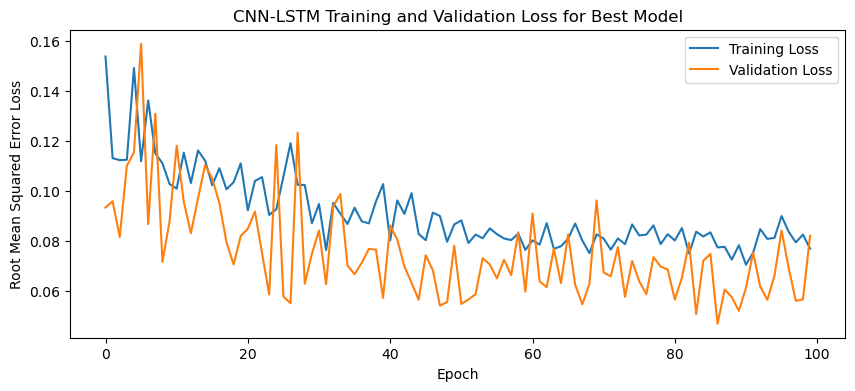

1/1 - 2s - loss: 0.0752 - 2s/epoch - 2s/step
Test Loss: 0.07518032193183899
Fold 2:
Epoch 1/100
19/19 [==============================] - 11s 148ms/step - loss: 0.2948 - val_loss: 0.1024
Epoch 2/100
19/19 [==============================] - 0s 23ms/step - loss: 0.1269 - val_loss: 0.0970
Epoch 3/100
19/19 [==============================] - 0s 24ms/step - loss: 0.0914 - val_loss: 0.1412
Epoch 4/100
19/19 [==============================] - 0s 23ms/step - loss: 0.1132 - val_loss: 0.1370
Epoch 5/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0966 - val_loss: 0.0814
Epoch 6/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0949 - val_loss: 0.0947
Epoch 7/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1011 - val_loss: 0.0949
Epoch 8/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0928 - val_loss: 0.0775
Epoch 9/100
19/19 [==============================] - 0s 20ms/step - loss: 0.1045 - val_loss: 0.0968
Epoch 10/100
1

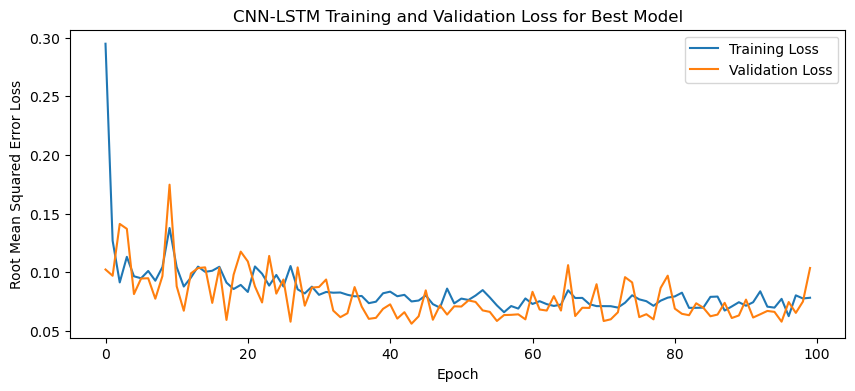

1/1 - 2s - loss: 0.1097 - 2s/epoch - 2s/step
Test Loss: 0.10972453653812408
Fold 3:
Epoch 1/100
19/19 [==============================] - 11s 108ms/step - loss: 0.2267 - val_loss: 0.1854
Epoch 2/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1484 - val_loss: 0.0709
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1155 - val_loss: 0.1550
Epoch 4/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1111 - val_loss: 0.0704
Epoch 5/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1274 - val_loss: 0.1080
Epoch 6/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0988 - val_loss: 0.0813
Epoch 7/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0997 - val_loss: 0.0719
Epoch 8/100
19/19 [==============================] - 0s 22ms/step - loss: 0.1246 - val_loss: 0.1374
Epoch 9/100
19/19 [==============================] - 0s 18ms/step - loss: 0.0937 - val_loss: 0.1123
Epoch 10/100
1

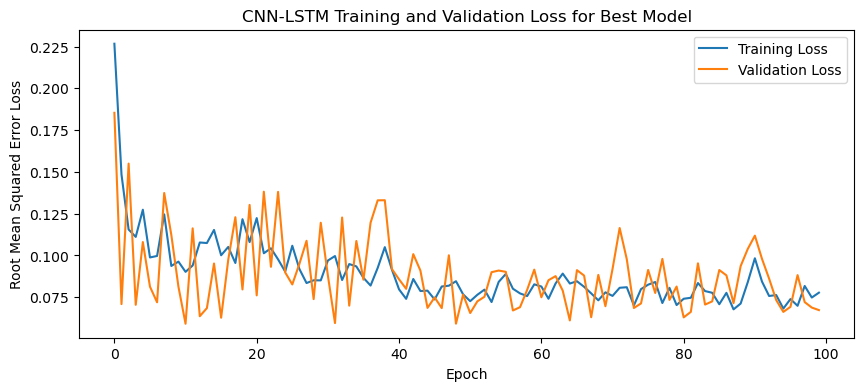

1/1 - 3s - loss: 0.0837 - 3s/epoch - 3s/step
Test Loss: 0.08365804702043533
Fold 4:
Epoch 1/100
20/20 [==============================] - 10s 102ms/step - loss: 0.2618 - val_loss: 0.1486
Epoch 2/100
20/20 [==============================] - 0s 18ms/step - loss: 0.1545 - val_loss: 0.1569
Epoch 3/100
20/20 [==============================] - 0s 18ms/step - loss: 0.1658 - val_loss: 0.1138
Epoch 4/100
20/20 [==============================] - 0s 18ms/step - loss: 0.1203 - val_loss: 0.1155
Epoch 5/100
20/20 [==============================] - 0s 14ms/step - loss: 0.1186 - val_loss: 0.1379
Epoch 6/100
20/20 [==============================] - 0s 18ms/step - loss: 0.1357 - val_loss: 0.0970
Epoch 7/100
20/20 [==============================] - 0s 18ms/step - loss: 0.1453 - val_loss: 0.1387
Epoch 8/100
20/20 [==============================] - 0s 17ms/step - loss: 0.1345 - val_loss: 0.1586
Epoch 9/100
20/20 [==============================] - 0s 19ms/step - loss: 0.1251 - val_loss: 0.1621
Epoch 10/100
2

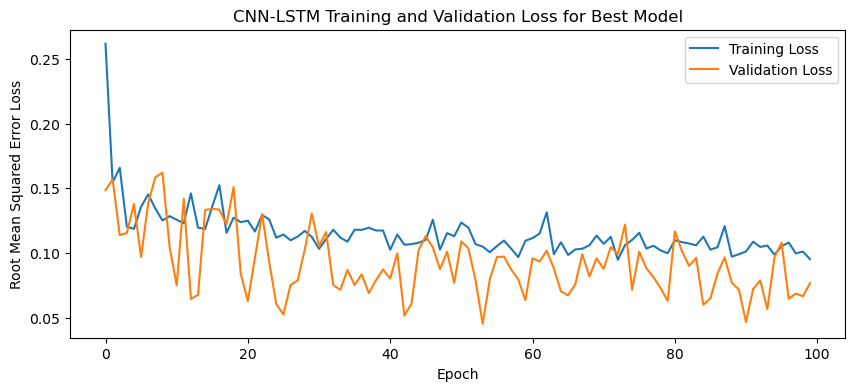

1/1 - 2s - loss: 0.1090 - 2s/epoch - 2s/step
Test Loss: 0.10901249200105667
Fold 5:
Epoch 1/100
19/19 [==============================] - 11s 112ms/step - loss: 0.2507 - val_loss: 0.1963
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1224 - val_loss: 0.1464
Epoch 3/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1425 - val_loss: 0.0841
Epoch 4/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1256 - val_loss: 0.0722
Epoch 5/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1393 - val_loss: 0.1179
Epoch 6/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1133 - val_loss: 0.1827
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1141 - val_loss: 0.1043
Epoch 8/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1225 - val_loss: 0.1563
Epoch 9/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1035 - val_loss: 0.1074
Epoch 10/100
19/19

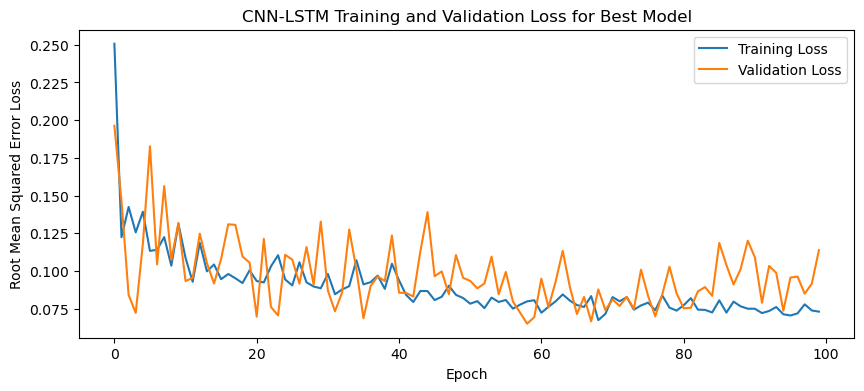

1/1 - 3s - loss: 0.0511 - 3s/epoch - 3s/step
Test Loss: 0.05108805373311043


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

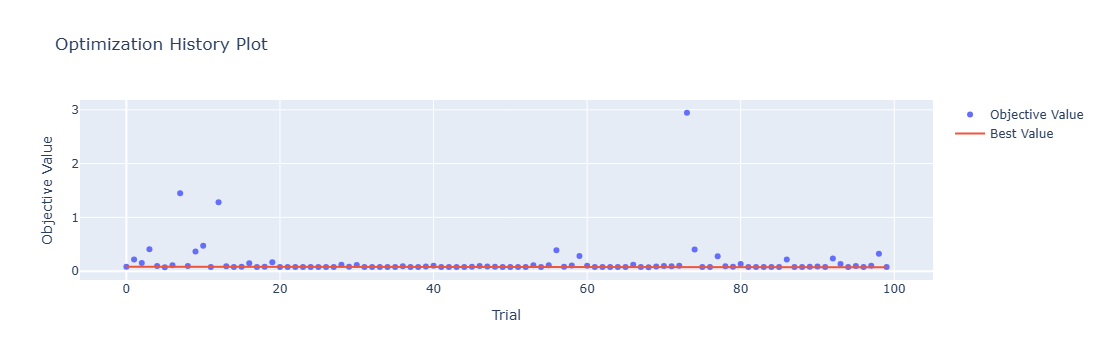

In [4]:
optuna.visualization.plot_optimization_history(study)

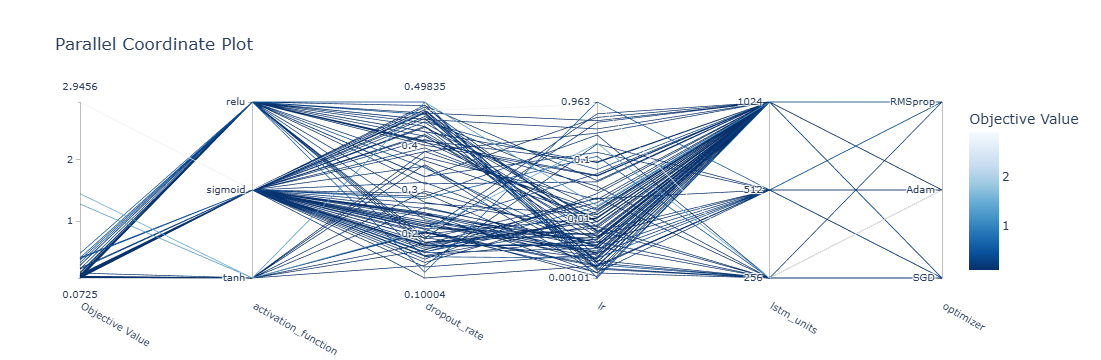

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

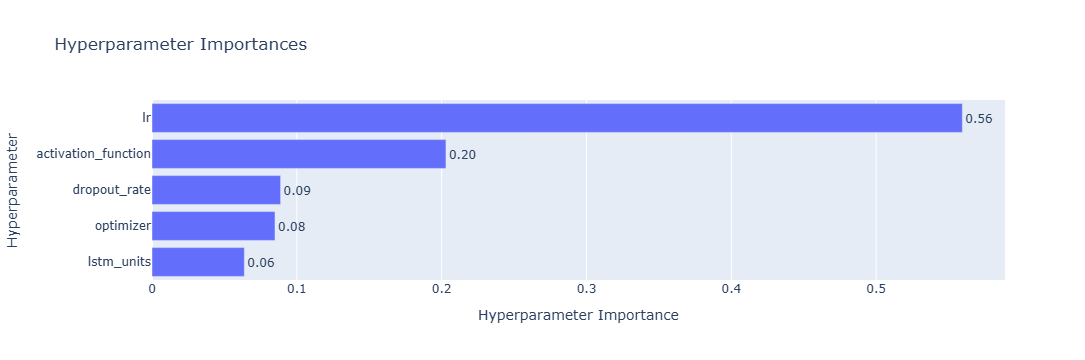

In [6]:
optuna.visualization.plot_param_importances(study)

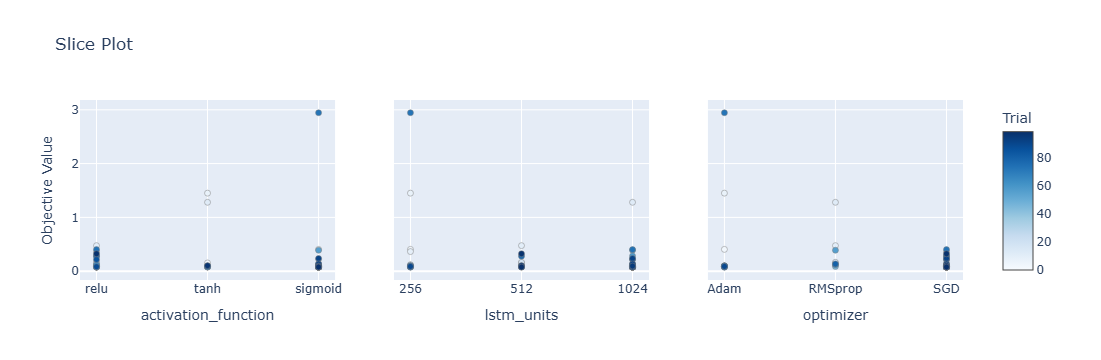

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

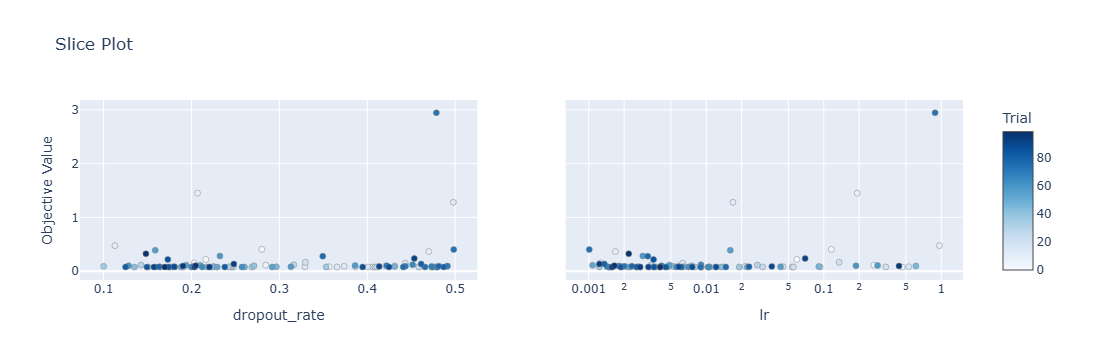

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 6s 75ms/step - loss: 0.3249 - accuracy: 0.1579 - mae: 0.2532 - rmse: 0.3249 - mape: 63.2373 - pearson: 0.1434 - val_loss: 0.0749 - val_accuracy: 0.6667 - val_mae: 0.0644 - val_rmse: 0.0749 - val_mape: 14.4175 - val_pearson: 0.2573
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1175 - accuracy: 0.3158 - mae: 0.0948 - rmse: 0.1175 - mape: 24.5555 - pearson: 0.4325 - val_loss: 0.1614 - val_accuracy: 0.0000e+00 - val_mae: 0.1317 - val_rmse: 0.1614 - val_mape: 30.4391 - val_pearson: 0.3515
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1404 - accuracy

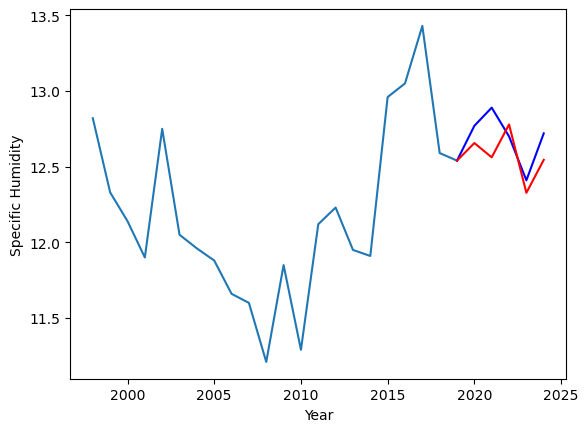

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.88		9.91		0.03
10.09		9.81		-0.28
9.65		10.03		0.38
9.13		9.58		0.45
9.32		9.79		0.47


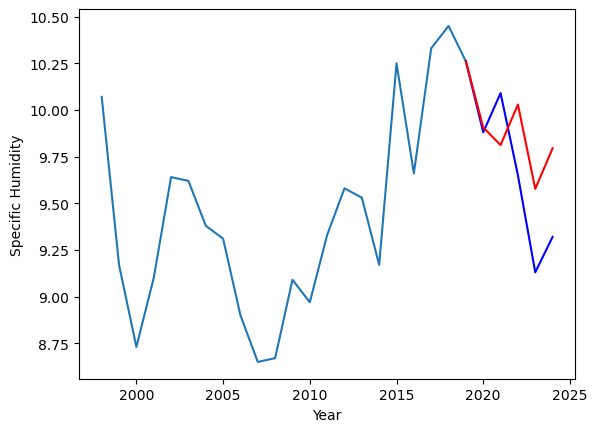

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.77  12.656115
1                1    9.88   9.906022


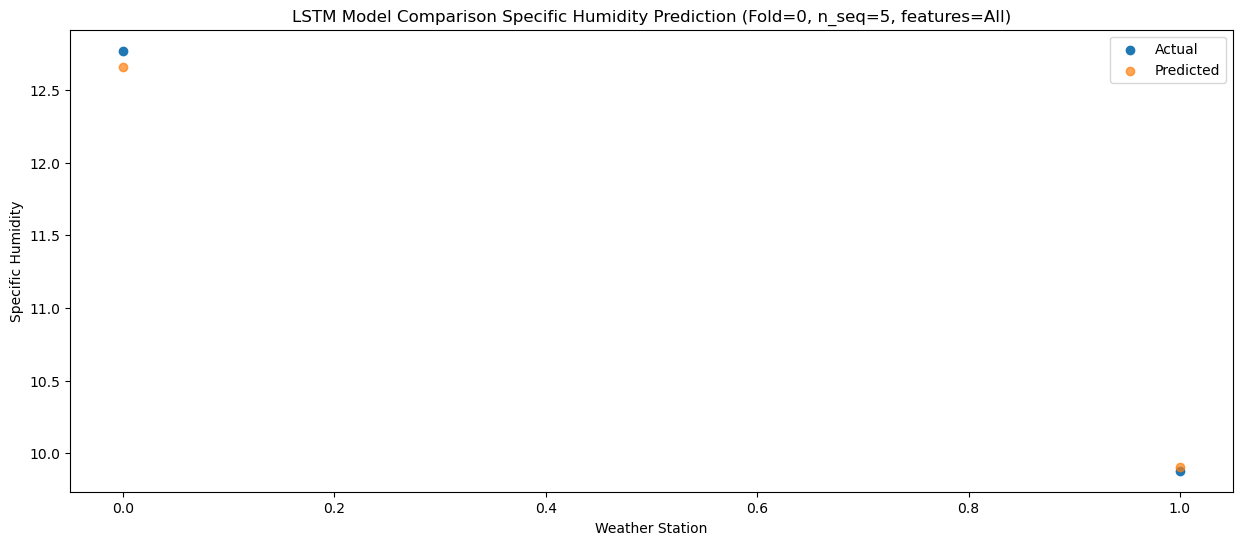

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.89  12.561899
1                1   10.09   9.811851


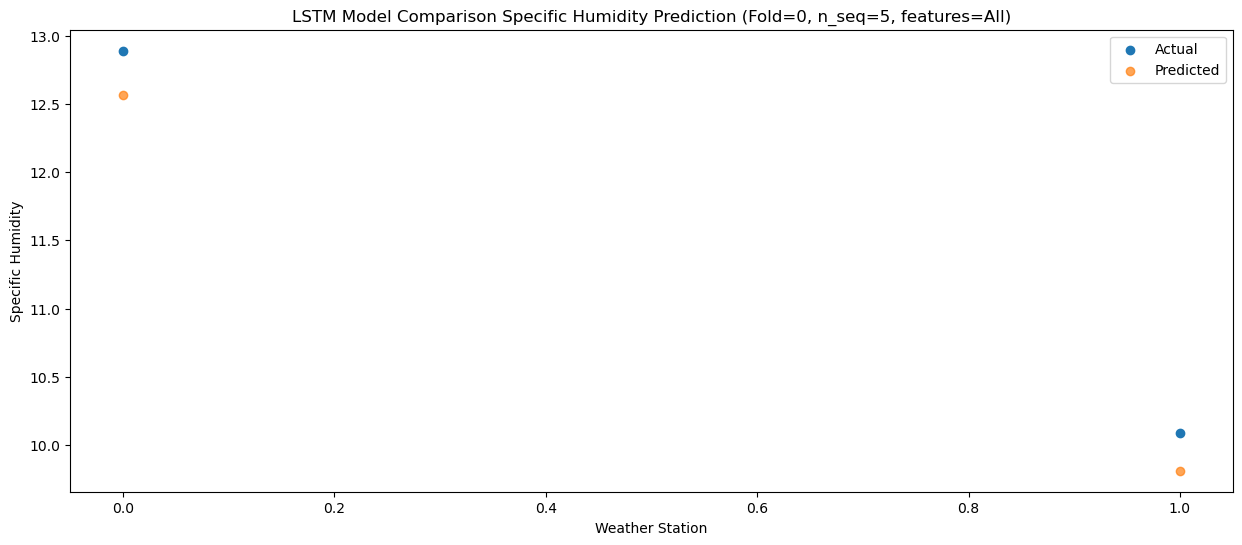

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.70  12.778994
1                1    9.65  10.028845


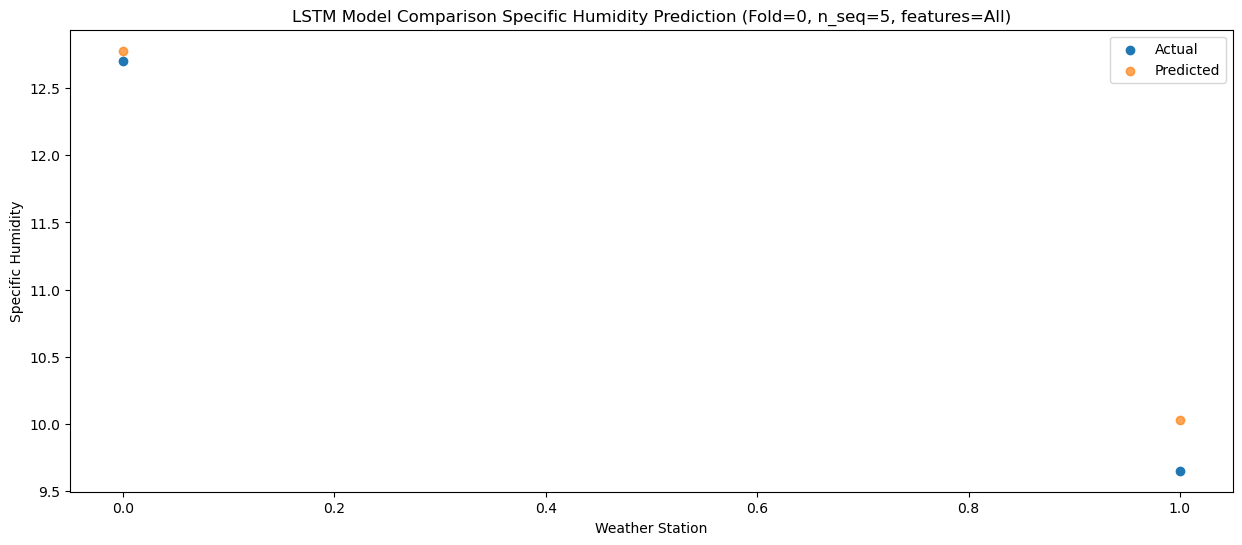

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.41  12.327240
1                1    9.13   9.577127


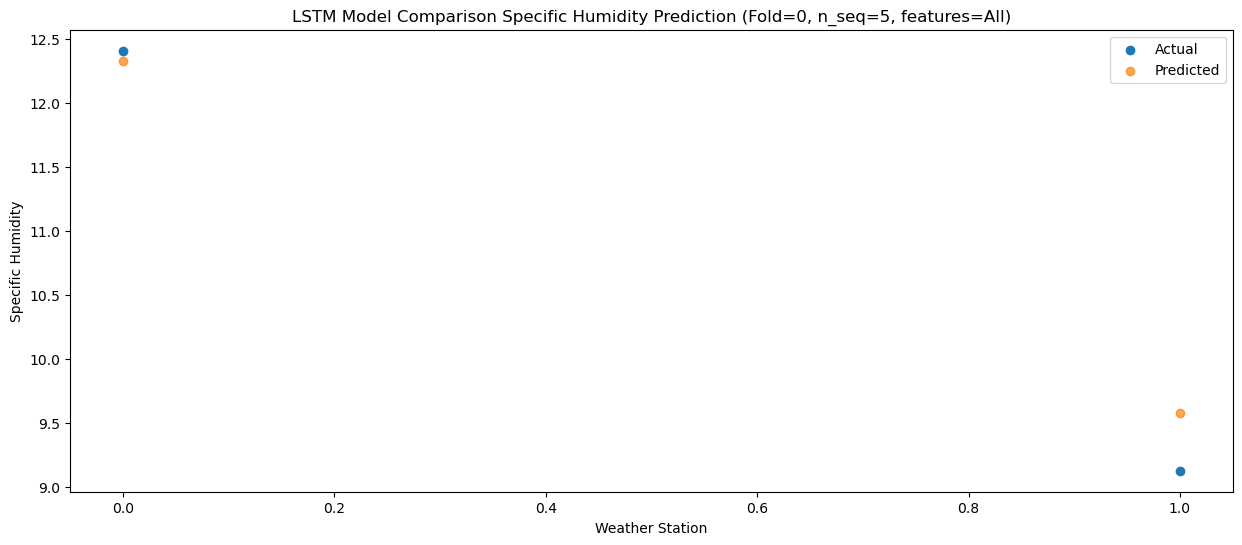

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.72   12.54484
1                1    9.32    9.79461


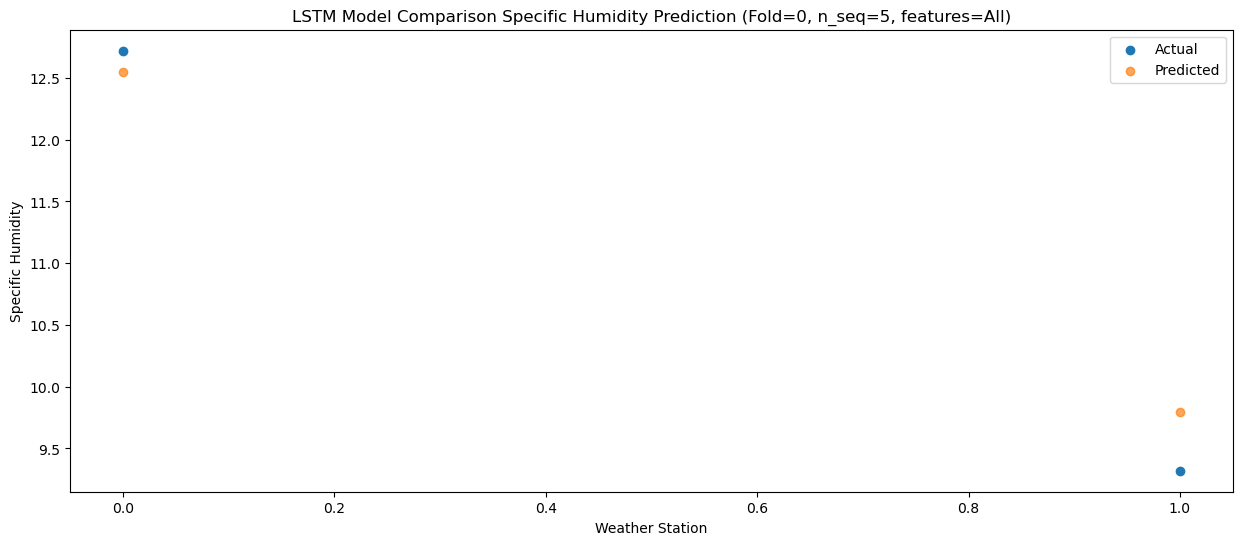

f, t:
[[12.77  9.88]
 [12.89 10.09]
 [12.7   9.65]
 [12.41  9.13]
 [12.72  9.32]]
[[12.65611502  9.90602162]
 [12.56189894  9.8118505 ]
 [12.7789944  10.02884547]
 [12.32724049  9.57712717]
 [12.54483961  9.79461016]]
Year at t+1:
t+1 SKRMSE: 0.082604
t+1 KRMSE: 0.082604
t+1 MAE: 0.069953
t+1 SKMAPE: 0.005776
t+1 R2_SCORE: 0.996732
t+1 KMAPE: 0.005776
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.325000
Year at t+2:
t+2 SKRMSE: 0.304152
t+2 KRMSE: 0.304152
t+2 MAE: 0.303125
t+2 SKMAPE: 0.026510
t+2 R2_SCORE: 0.952802
t+2 KMAPE: 0.026510
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 11.490000
Year at t+3:
t+3 SKRMSE: 0.273646
t+3 KRMSE: 0.273646
t+3 MAE: 0.228920
t+3 SKMAPE: 0.022739
t+3 R2_SCORE: 0.967801
t+3 KMAPE: 0.022739
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 11.175000
Year at t+4:
t+4 SKRMSE: 0.321537
t+4 KRMSE: 0.321537
t+4 MAE: 0.264943
t+4 SKMAPE: 0.027821
t+4 R2_SCORE: 0.961561
t+4 KMAPE: 0.027821
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 10.770000
Year at t+5:
t+5 SKRMSE: 0.357

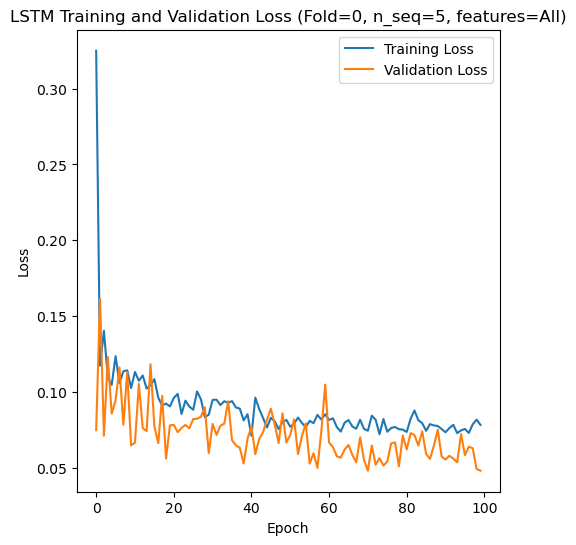

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 5s 74ms/step - loss: 0.1376 - accuracy: 0.3684 - mae: 0.1186 - rmse: 0.1376 - mape: 29.1240 - pearson: 0.2979 - val_loss: 0.0735 - val_accuracy: 0.3333 - val_mae: 0.0590 - val_rmse: 0.0735 - val_mape: 13.9413 - val_pearson: 0.6454
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1110 - accuracy: 0.1053 - mae: 0.0978 - rmse: 0.1110 - mape: 23.4514 - pearson: 0.2542 - val_loss: 0.1495 - val_accuracy: 0.0000e+00 - val_mae: 0.1241 - val_rmse: 0.1495 - val_mape: 28.4035 - val_pearson: 0.5188
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1319 - accuracy

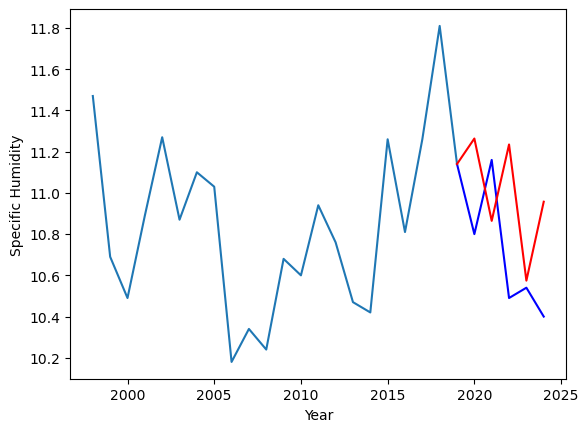

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.66		7.42		-0.24
6.92		7.02		0.10
7.36		7.40		0.04
6.79		6.74		-0.05
6.94		7.12		0.18


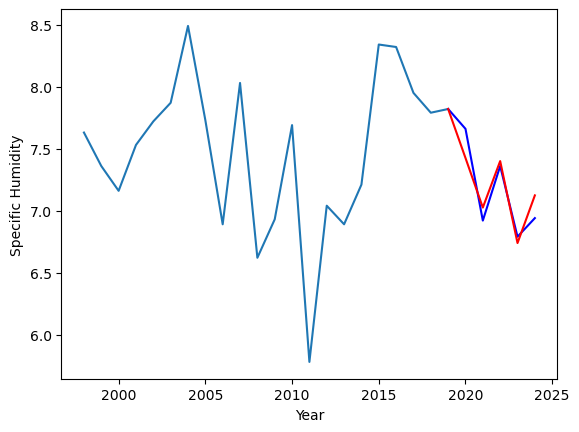

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.263702
1                1    7.66   7.424866


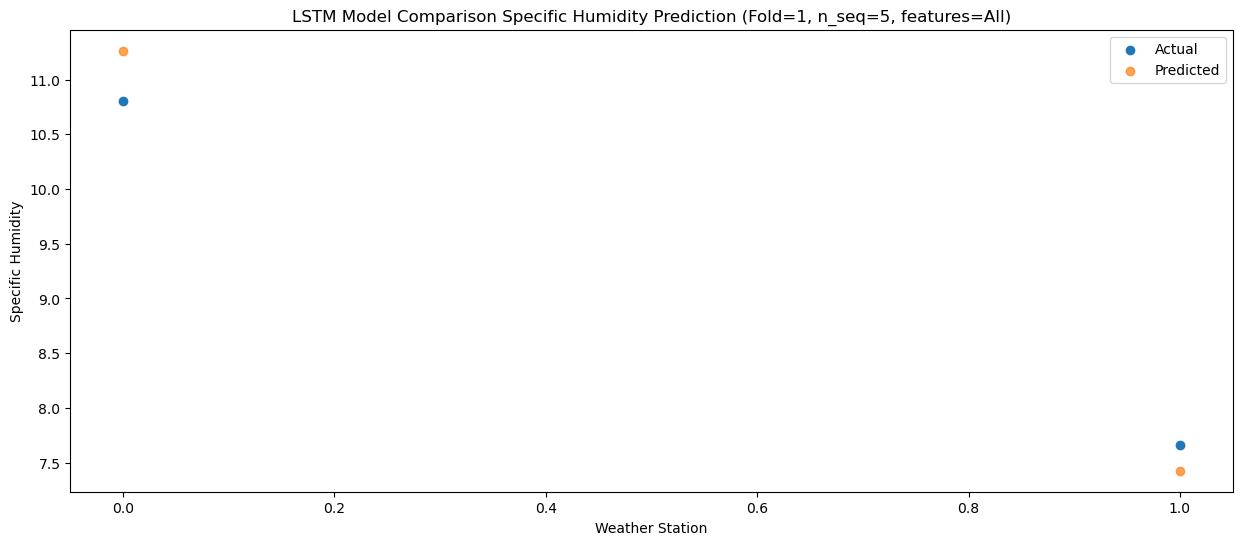

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.16  10.864302
1                1    6.92   7.024996


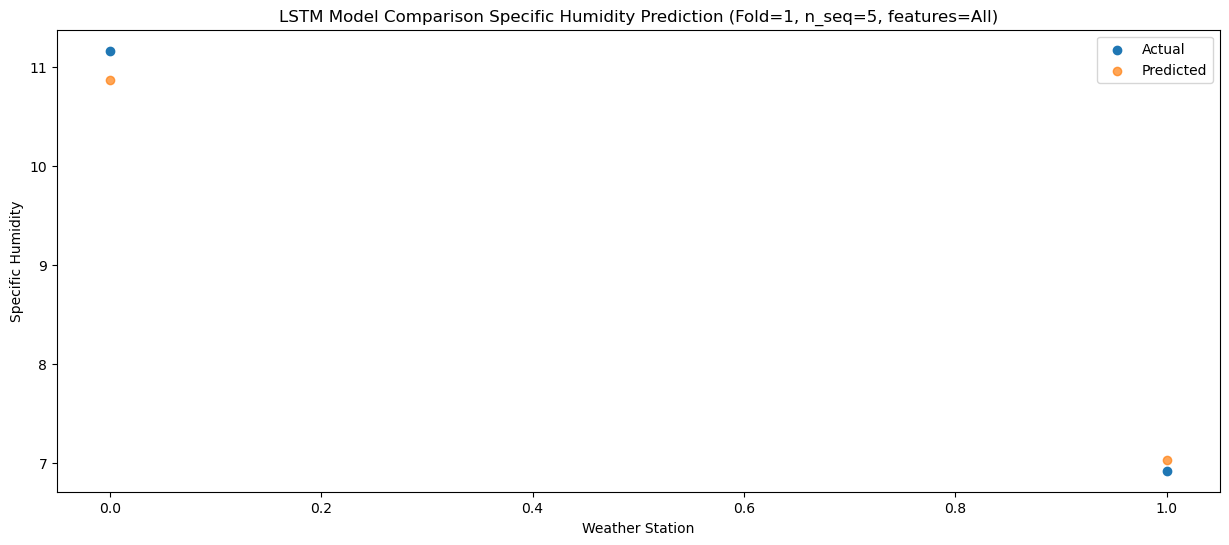

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.49  11.234927
1                1    7.36   7.399800


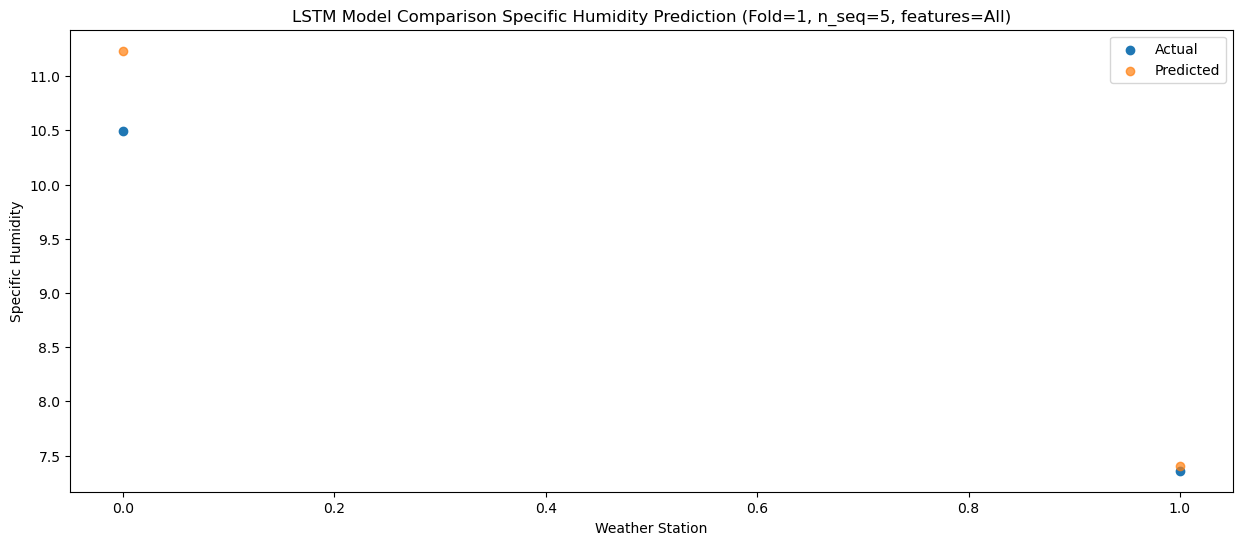

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.54  10.574265
1                1    6.79   6.738826


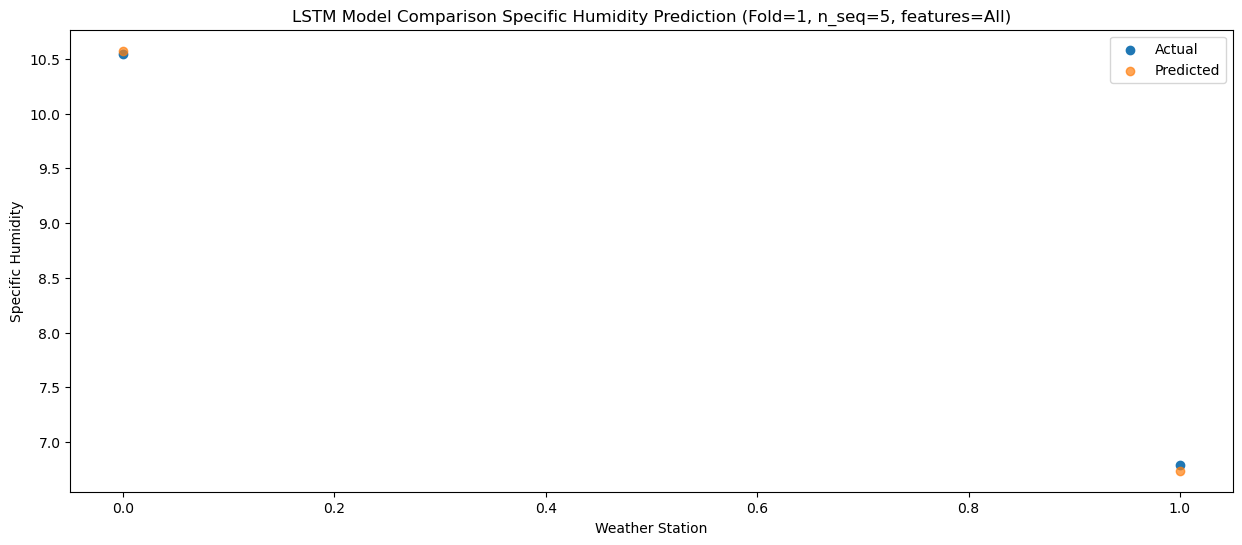

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   10.40  10.957173
1                1    6.94   7.123239


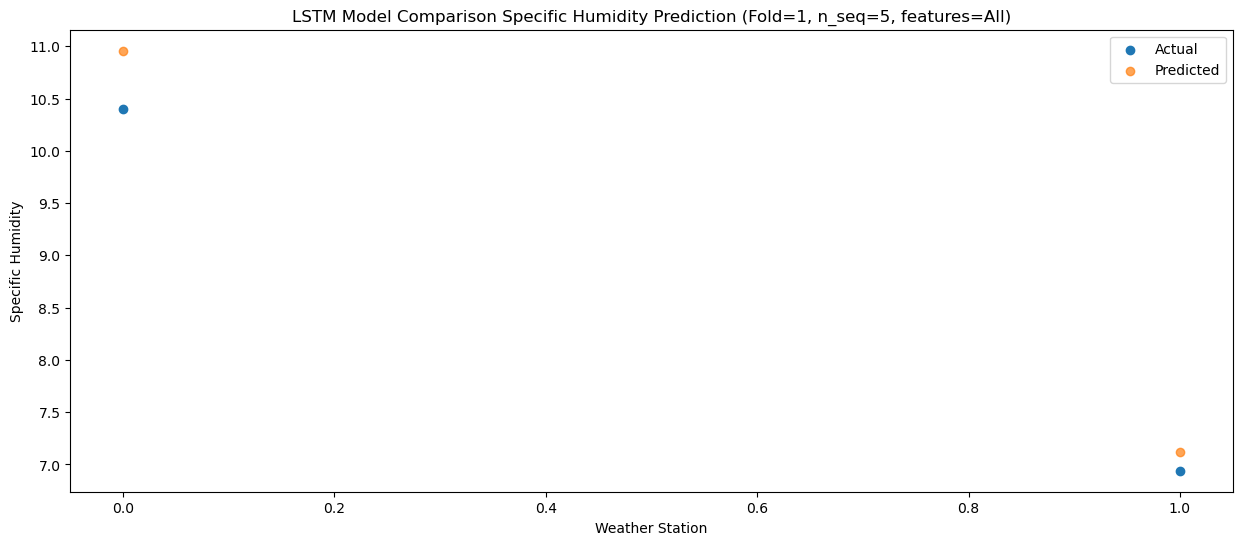

f, t:
[[10.8   7.66]
 [11.16  6.92]
 [10.49  7.36]
 [10.54  6.79]
 [10.4   6.94]]
[[11.26370232  7.42486643]
 [10.86430182  7.02499591]
 [11.23492743  7.39979999]
 [10.57426538  6.73882555]
 [10.95717253  7.12323879]]
Year at t+1:
t+1 SKRMSE: 0.367633
t+1 KRMSE: 0.367633
t+1 MAE: 0.349418
t+1 SKMAPE: 0.036816
t+1 R2_SCORE: 0.945169
t+1 KMAPE: 0.036816
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.230000
Year at t+2:
t+2 SKRMSE: 0.221880
t+2 KRMSE: 0.221880
t+2 MAE: 0.200347
t+2 SKMAPE: 0.020835
t+2 R2_SCORE: 0.989046
t+2 KMAPE: 0.020835
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.040000
Year at t+3:
t+3 SKRMSE: 0.527495
t+3 KRMSE: 0.527495
t+3 MAE: 0.392364
t+3 SKMAPE: 0.038210
t+3 R2_SCORE: 0.886392
t+3 KMAPE: 0.038210
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.925000
Year at t+4:
t+4 SKRMSE: 0.043548
t+4 KRMSE: 0.043548
t+4 MAE: 0.042720
t+4 SKMAPE: 0.005394
t+4 R2_SCORE: 0.999461
t+4 KMAPE: 0.005394
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.665000
Year at t+5:
t+5 SKRMSE: 0.414739


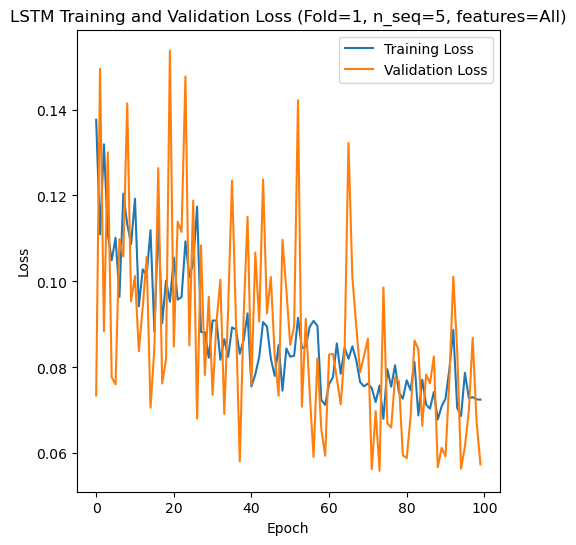

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 6s 73ms/step - loss: 0.1788 - accuracy: 0.1579 - mae: 0.1414 - rmse: 0.1788 - mape: 32.7870 - pearson: 0.1692 - val_loss: 0.1341 - val_accuracy: 0.0000e+00 - val_mae: 0.1119 - val_rmse: 0.1341 - val_mape: 27.7787 - val_pearson: 0.0209
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1240 - accuracy: 0.1579 - mae: 0.1057 - rmse: 0.1240 - mape: 26.7008 - pearson: 0.2717 - val_loss: 0.0938 - val_accuracy: 0.3333 - val_mae: 0.0772 - val_rmse: 0.0938 - val_mape: 18.6572 - val_pearson: 0.5705
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1008 - accuracy

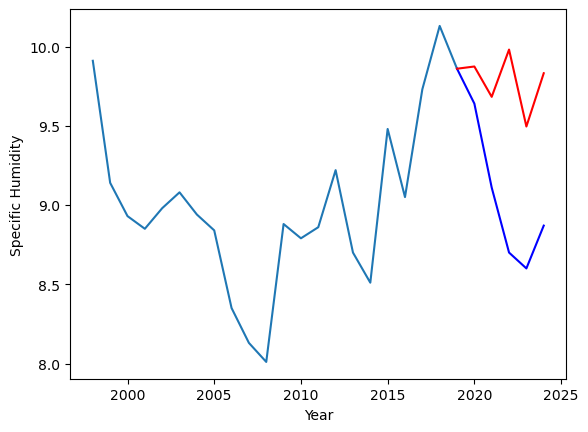

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.84		8.44		0.60
7.66		8.25		0.59
7.73		8.56		0.83
8.00		8.07		0.07
8.01		8.41		0.40


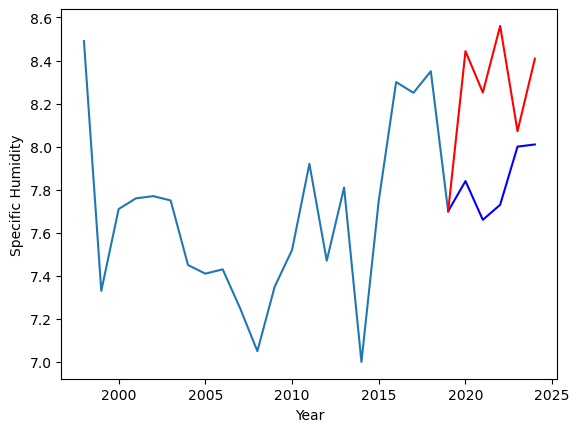

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.64   9.873977
1                1    7.84   8.443563


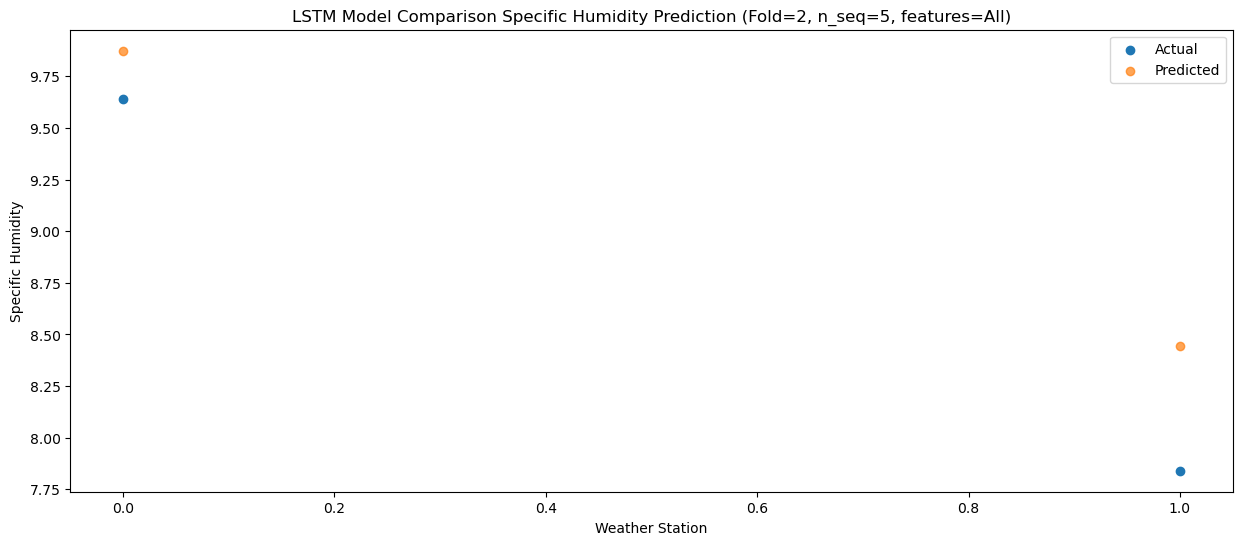

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    9.11   9.682529
1                1    7.66   8.251478


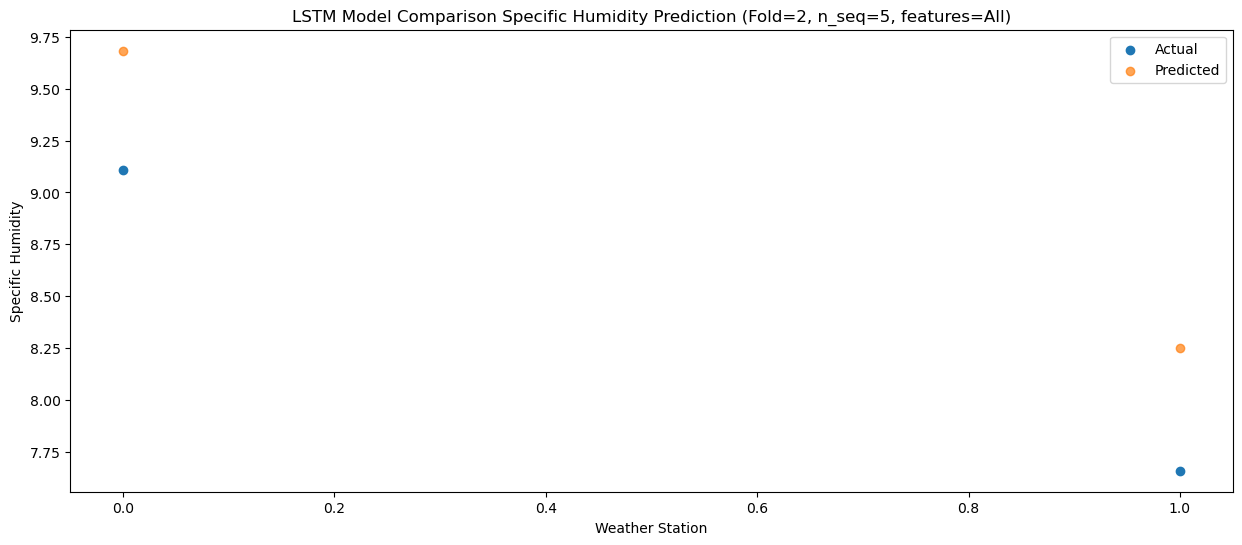

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    8.70   9.980781
1                1    7.73   8.560690


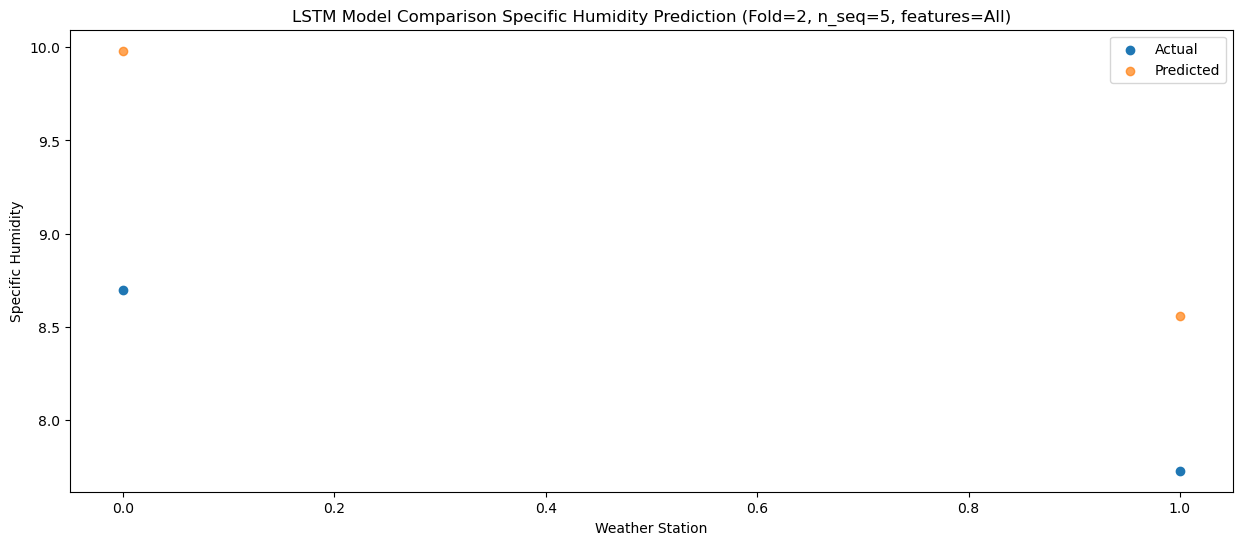

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0     8.6   9.495358
1                1     8.0   8.071564


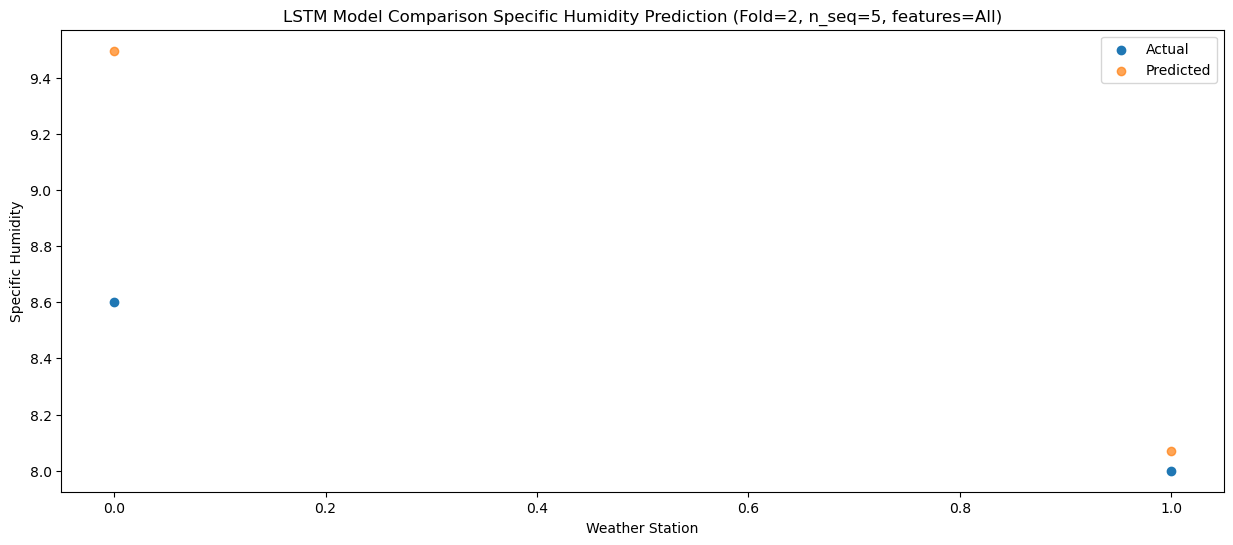

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    8.87   9.831504
1                1    8.01   8.408155


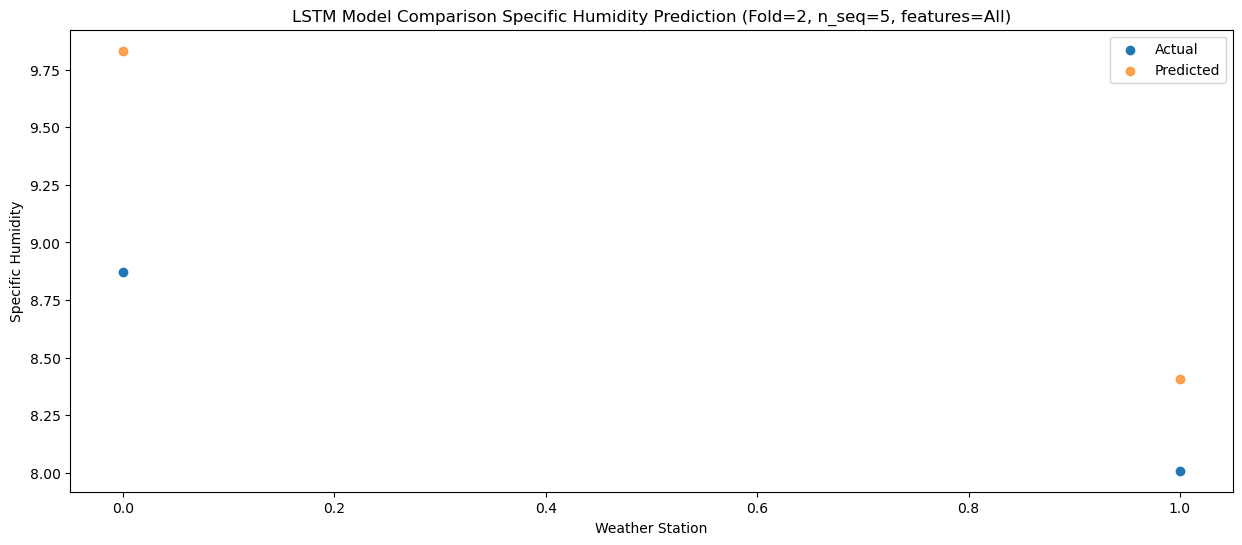

f, t:
[[9.64 7.84]
 [9.11 7.66]
 [8.7  7.73]
 [8.6  8.  ]
 [8.87 8.01]]
[[9.87397718 8.44356315]
 [9.68252862 8.25147836]
 [9.98078135 8.56068956]
 [9.49535809 8.07156415]
 [9.83150376 8.40815468]]
Year at t+1:
t+1 SKRMSE: 0.457730
t+1 KRMSE: 0.457730
t+1 MAE: 0.418770
t+1 SKMAPE: 0.050628
t+1 R2_SCORE: 0.741337
t+1 KMAPE: 0.050628
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.740000
Year at t+2:
t+2 SKRMSE: 0.582081
t+2 KRMSE: 0.582081
t+2 MAE: 0.582003
t+2 SKMAPE: 0.070031
t+2 R2_SCORE: 0.355400
t+2 KMAPE: 0.070031
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 8.385000
Year at t+3:
t+3 SKRMSE: 1.079455
t+3 KRMSE: 1.079455
t+3 MAE: 1.055735
t+3 SKMAPE: 0.127340
t+3 R2_SCORE: -3.953653
t+3 KMAPE: 0.127340
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.215000
Year at t+4:
t+4 SKRMSE: 0.635133
t+4 KRMSE: 0.635133
t+4 MAE: 0.483461
t+4 SKMAPE: 0.056528
t+4 R2_SCORE: -3.482153
t+4 KMAPE: 0.056528
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.300000
Year at t+5:
t+5 SKRMSE: 0.735872
t+5 KRMSE: 0.73587

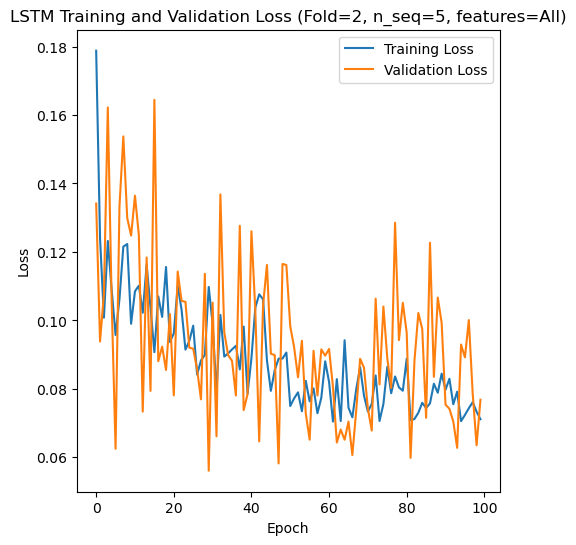

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 5s 79ms/step - loss: 0.2392 - accuracy: 0.1500 - mae: 0.2040 - rmse: 0.2392 - mape: 36.4584 - pearson: 0.2114 - val_loss: 0.2445 - val_accuracy: 0.5000 - val_mae: 0.2118 - val_rmse: 0.2445 - val_mape: 35.8137 - val_pearson: 0.3556
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1799 - accuracy: 0.1000 - mae: 0.1543 - rmse: 0.1799 - mape: 27.8774 - pearson: 0.2694 - val_loss: 0.1223 - val_accuracy: 0.5000 - val_mae: 0.1082 - val_rmse: 0.1223 - val_mape: 18.4088 - val_pearson: 0.9104
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1393 - accuracy: 0.3500 - mae: 0.1200 - rmse: 0.1393 - mape: 22.3406 - pearso

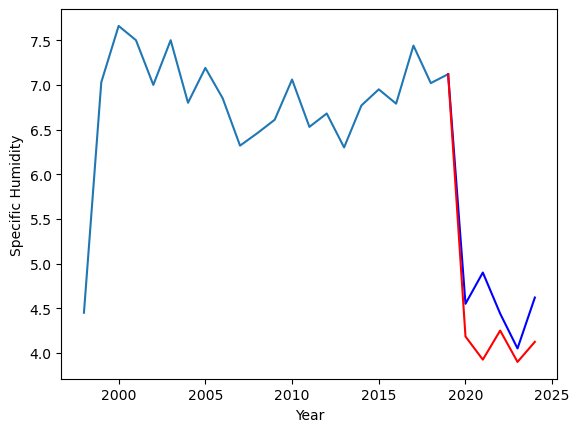

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.21		8.06		-0.15
8.12		7.80		-0.32
8.09		8.13		0.04
7.62		7.78		0.16
7.64		8.00		0.36


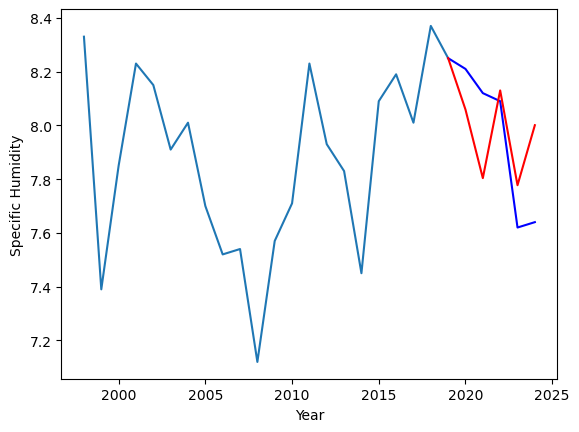

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.55   4.184018
1                1    8.21   8.058751


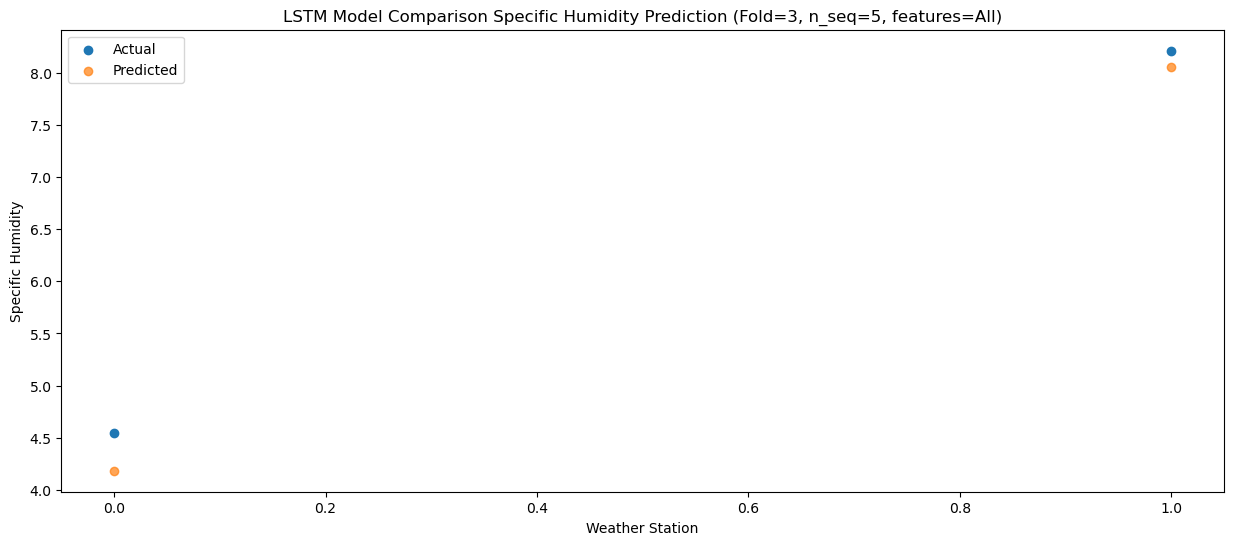

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    4.90   3.925075
1                1    8.12   7.803783


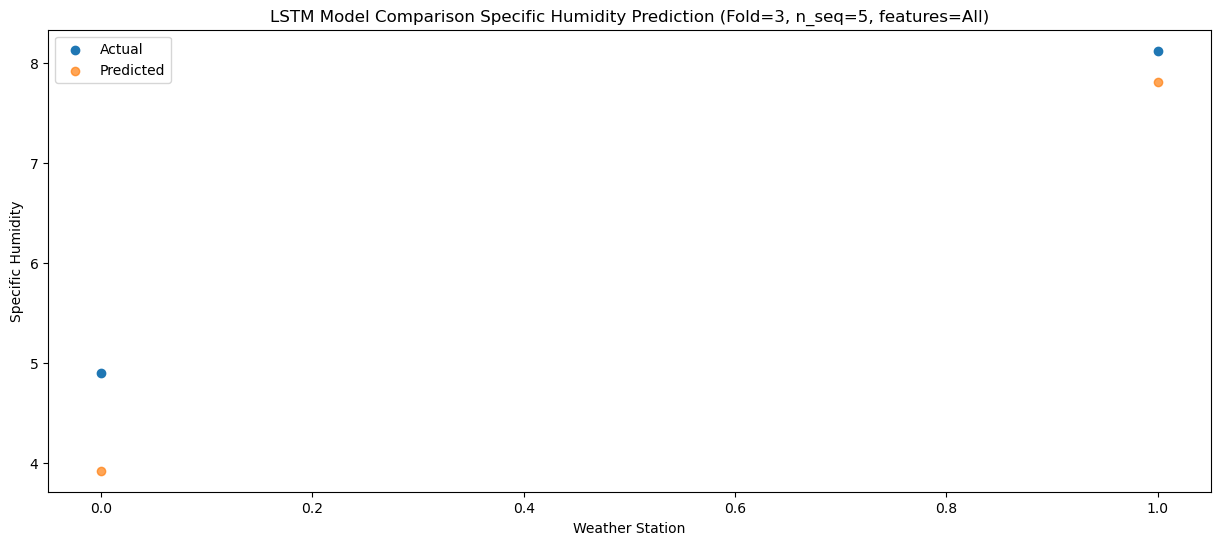

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.44   4.250475
1                1    8.09   8.130058


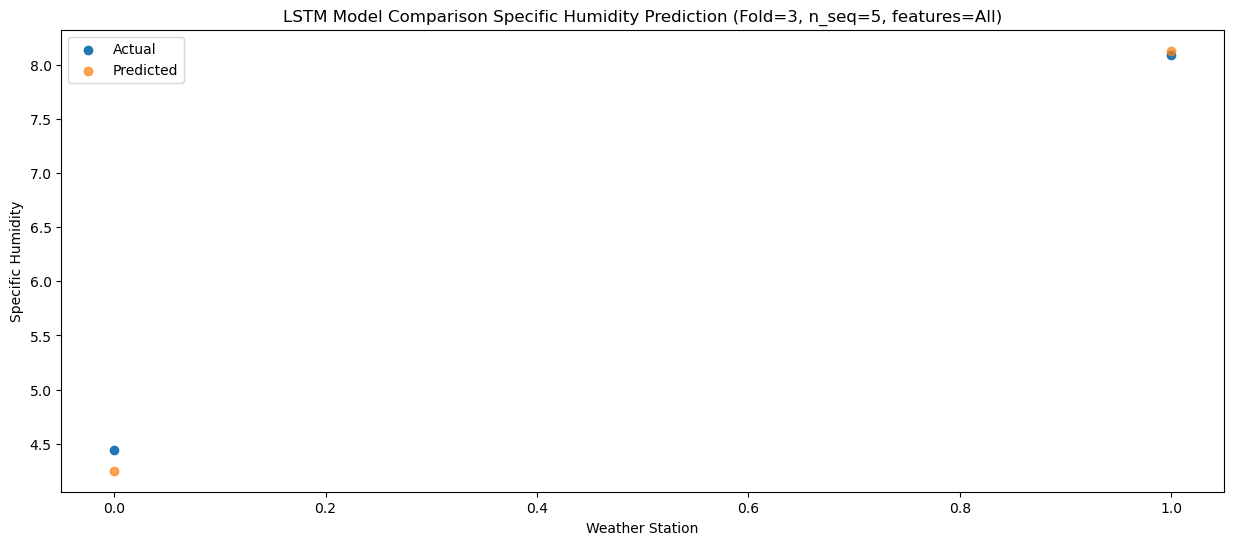

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    4.05   3.899367
1                1    7.62   7.777414


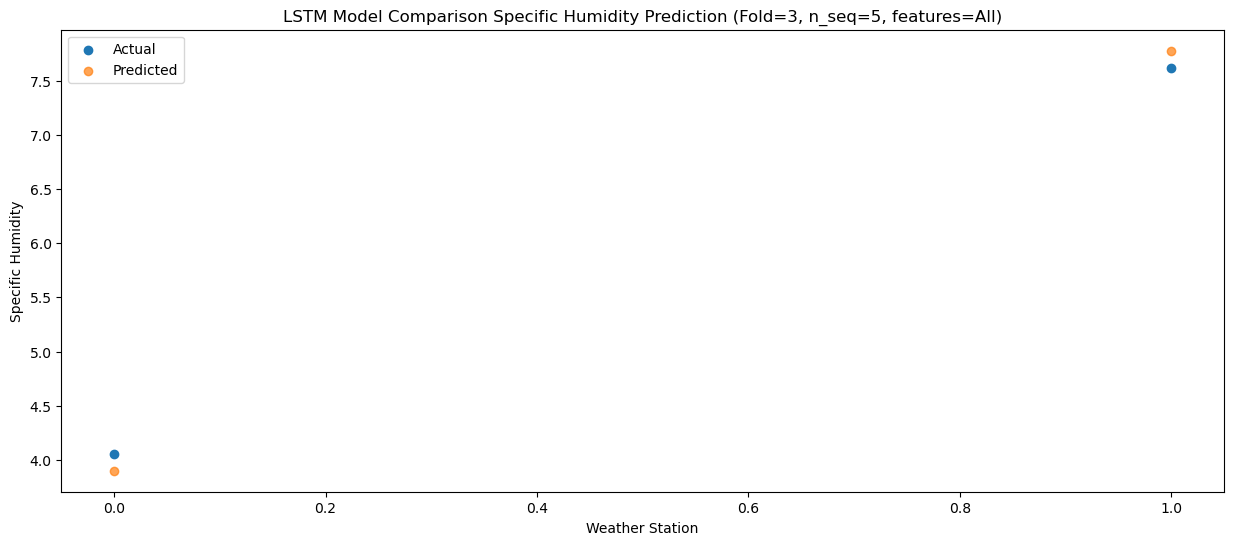

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    4.62   4.124184
1                1    7.64   8.000684


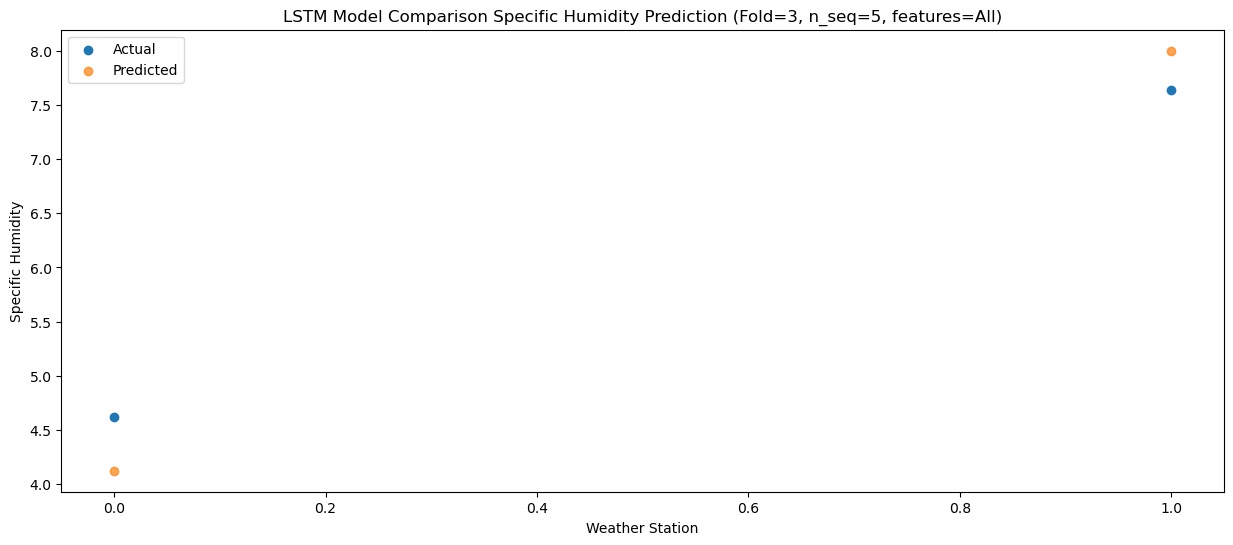

f, t:
[[4.55 8.21]
 [4.9  8.12]
 [4.44 8.09]
 [4.05 7.62]
 [4.62 7.64]]
[[4.18401767 8.05875127]
 [3.92507498 7.80378334]
 [4.25047503 8.13005786]
 [3.89936657 7.77741359]
 [4.12418362 8.00068416]]
Year at t+1:
t+1 SKRMSE: 0.280017
t+1 KRMSE: 0.280017
t+1 MAE: 0.258616
t+1 SKMAPE: 0.049429
t+1 R2_SCORE: 0.976586
t+1 KMAPE: 0.049429
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.380000
Year at t+2:
t+2 SKRMSE: 0.724732
t+2 KRMSE: 0.724732
t+2 MAE: 0.645571
t+2 SKMAPE: 0.118954
t+2 R2_SCORE: 0.797371
t+2 KMAPE: 0.118954
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.510000
Year at t+3:
t+3 SKRMSE: 0.136975
t+3 KRMSE: 0.136975
t+3 MAE: 0.114791
t+3 SKMAPE: 0.023819
t+3 R2_SCORE: 0.994367
t+3 KMAPE: 0.023819
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.265000
Year at t+4:
t+4 SKRMSE: 0.154061
t+4 KRMSE: 0.154061
t+4 MAE: 0.154024
t+4 SKMAPE: 0.028926
t+4 R2_SCORE: 0.992551
t+4 KMAPE: 0.028926
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 5.835000
Year at t+5:
t+5 SKRMSE: 0.433548
t+5 KRMSE: 0.433548


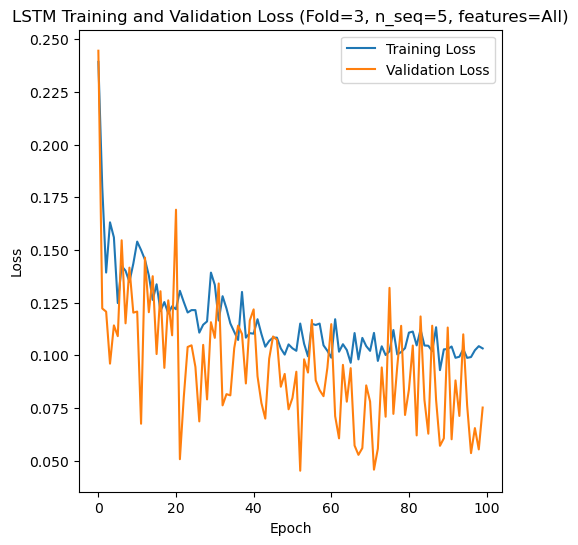

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 5s 74ms/step - loss: 0.1935 - accuracy: 0.2632 - mae: 0.1624 - rmse: 0.1935 - mape: 40.8896 - pearson: 0.3755 - val_loss: 0.1092 - val_accuracy: 0.0000e+00 - val_mae: 0.0933 - val_rmse: 0.1092 - val_mape: 21.2692 - val_pearson: 0.2360
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1131 - accuracy: 0.2105 - mae: 0.0968 - rmse: 0.1131 - mape: 24.3292 - pearson: 0.1699 - val_loss: 0.1191 - val_accuracy: 0.0000e+00 - val_mae: 0.1039 - val_rmse: 0.1191 - val_mape: 25.7904 - val_pearson: 0.0750
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1149 - accur

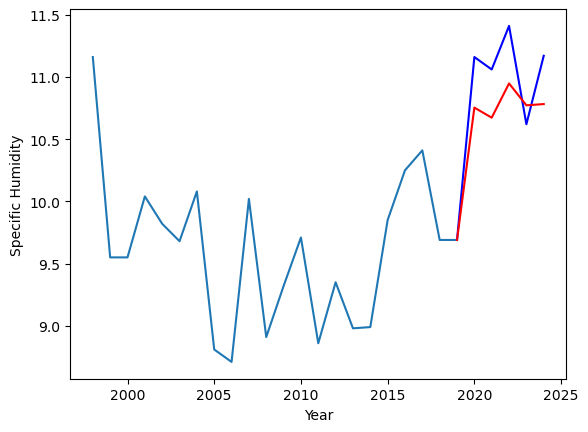

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.79		7.91		0.12
7.52		7.85		0.33
7.85		8.15		0.30
7.25		7.98		0.73
7.48		8.00		0.52


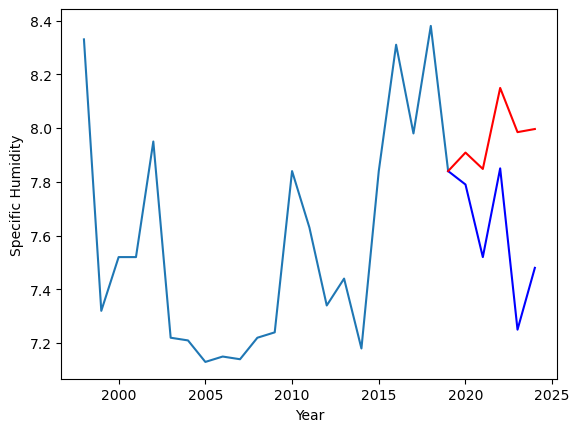

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.16  10.753619
1                1    7.79   7.908786


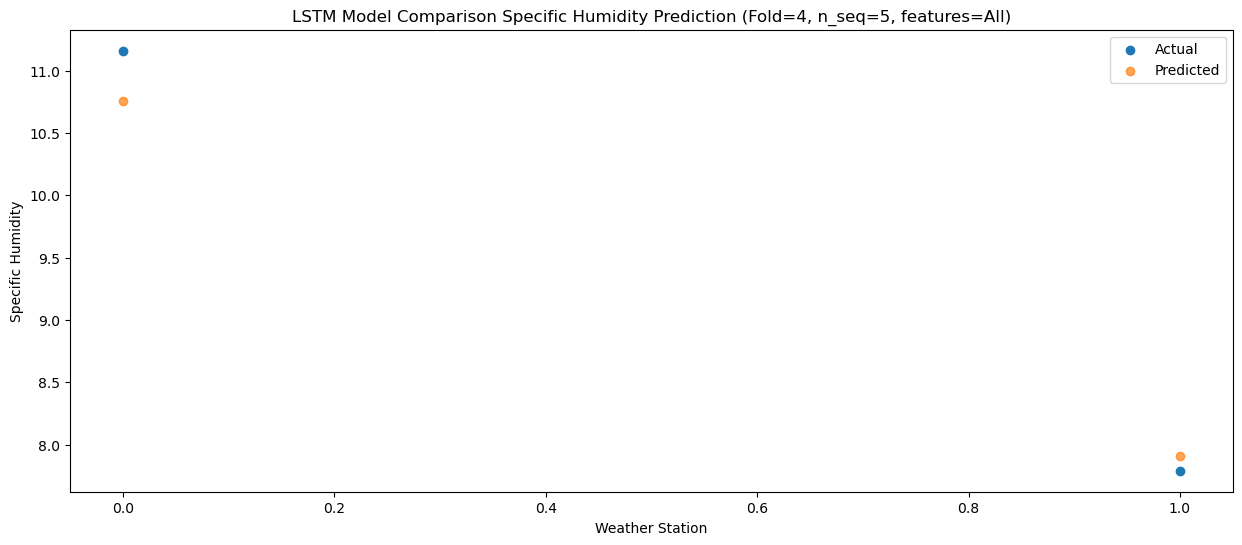

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.06  10.672671
1                1    7.52   7.847883


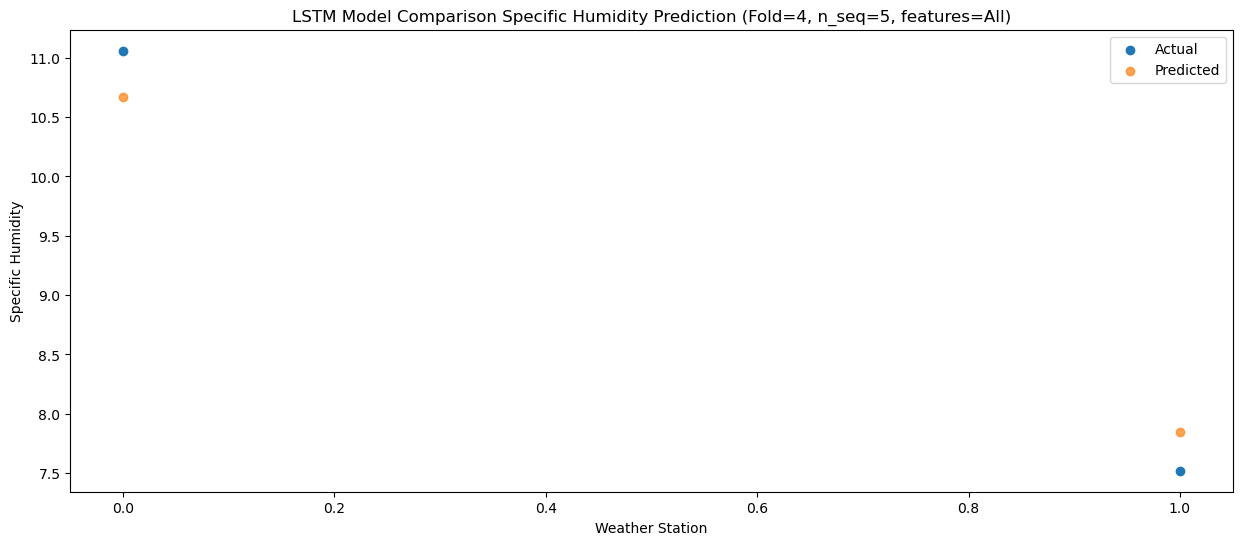

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.41  10.947754
1                1    7.85   8.149256


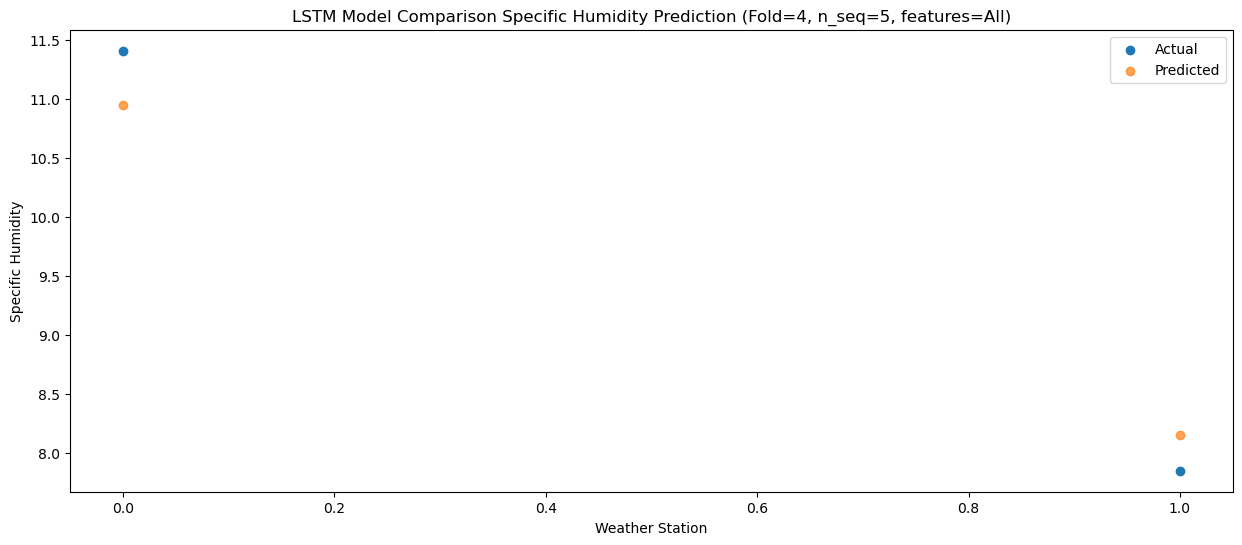

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.62  10.772073
1                1    7.25   7.984834


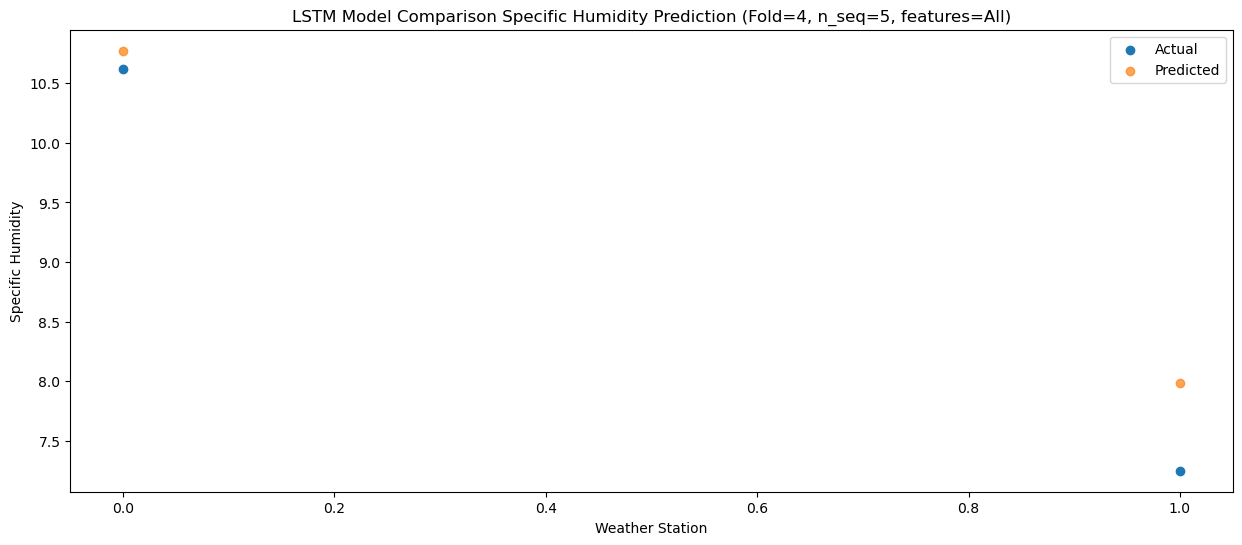

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.17  10.782060
1                1    7.48   7.996461


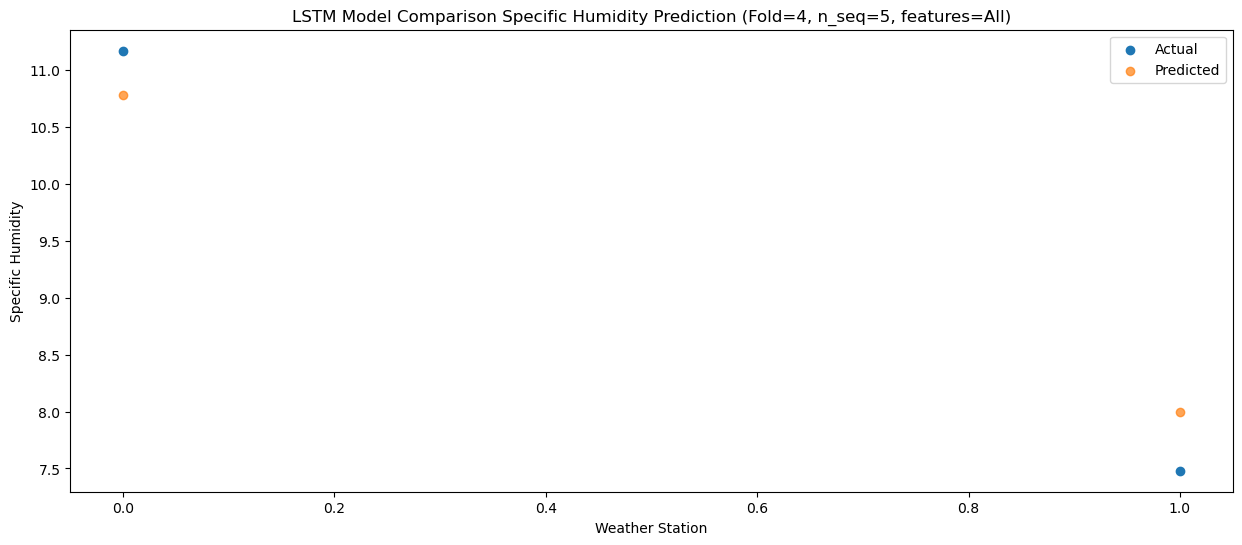

f, t:
[[11.16  7.79]
 [11.06  7.52]
 [11.41  7.85]
 [10.62  7.25]
 [11.17  7.48]]
[[10.75361869  7.90878587]
 [10.67267138  7.84788251]
 [10.94775433  8.14925629]
 [10.77207345  7.98483398]
 [10.78205988  7.99646124]]
Year at t+1:
t+1 SKRMSE: 0.299379
t+1 KRMSE: 0.299379
t+1 MAE: 0.262584
t+1 SKMAPE: 0.025831
t+1 R2_SCORE: 0.968432
t+1 KMAPE: 0.025831
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.475000
Year at t+2:
t+2 SKRMSE: 0.358839
t+2 KRMSE: 0.358839
t+2 MAE: 0.357606
t+2 SKMAPE: 0.039311
t+2 R2_SCORE: 0.958899
t+2 KMAPE: 0.039311
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.290000
Year at t+3:
t+3 SKRMSE: 0.389375
t+3 KRMSE: 0.389375
t+3 MAE: 0.380751
t+3 SKMAPE: 0.039317
t+3 R2_SCORE: 0.952148
t+3 KMAPE: 0.039317
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.630000
Year at t+4:
t+4 SKRMSE: 0.530616
t+4 KRMSE: 0.530616
t+4 MAE: 0.443454
t+4 SKMAPE: 0.057838
t+4 R2_SCORE: 0.900834
t+4 KMAPE: 0.057838
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.935000
Year at t+5:
t+5 SKRMSE: 0.456744


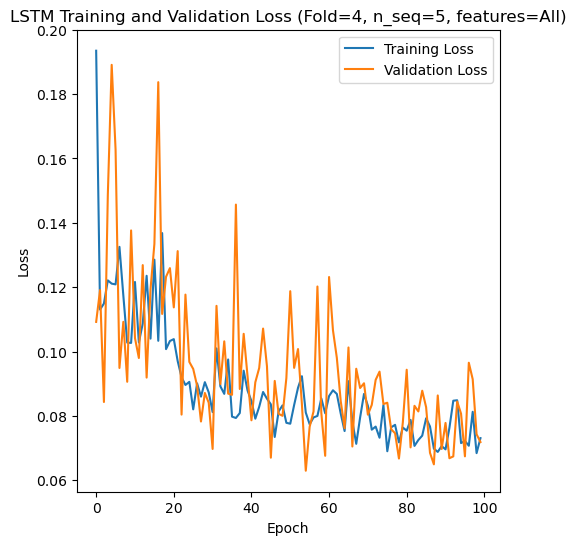

[[0.2848045259421011], [0.35680256944868183], [0.7291721086495376], [0.4084374832004135], [0.4147708647335444]]
[[array(0.28480453)], [array(0.35680257)], [array(0.72917211)], [array(0.40843748)], [array(0.41477086)]]
[[0.23836542636156074], [0.2710108560323716], [0.6439598899483685], [0.32025031250715263], [0.3793189056254926]]
[[0.023038782058482244], [0.02824867586162938], [0.07671622230884002], [0.05967836593487773], [0.04283709241254479]]
[[0.9669226969269351], [0.9605957880821793], [-0.32517487496364605], [0.9444148783669751], [0.9450453682374185]]
[[array(0.02303878)], [array(0.02824868)], [array(0.07671622)], [array(0.05967837)], [array(0.04283709)]]
[[array(0.97894653)], [array(0.97586218)], [array(0.78241043)], [array(0.97679493)], [array(0.98461242)]]
[12.77 12.89 12.7  12.41 12.72  9.88 10.09  9.65  9.13  9.32 10.8  11.16
 10.49 10.54 10.4   7.66  6.92  7.36  6.79  6.94  9.64  9.11  8.7   8.6
  8.87  7.84  7.66  7.73  8.    8.01  4.55  4.9   4.44  4.05  4.62  8.21
  8.12  8

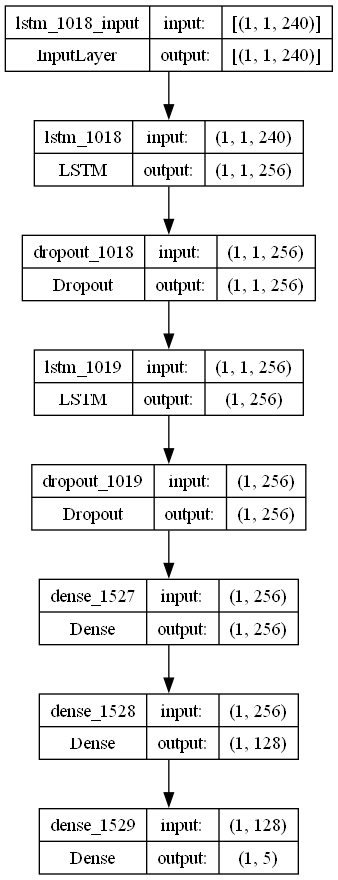

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.001492736244158803
    optimizer = Adam(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 256
    dropout_rate = 0.47937215085440626

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S5.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)